<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      n_a_dts = S_dict['n_a_dts']
      a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, a_rid])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


In [ ]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [ ]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [ ]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [ ]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0], dictio_obser_fixed_copy['y_train'], full_masks[i])
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[ 1.08251052 -1.13647048 -2.05557756  1.12678364  0.45769555  0.44361212
  0.79143355 -1.68659796 -1.27796536  1.96807161 -0.66939769 -1.07748473]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+01,
         1.59913999e+01,  3.47399149e+00,  1.40314719e+01,
         1.24512173e+01,  3.84026974e+01,  5.19847469e-01],
       [ 1.01289766e+01,  5.67996950e-01,  4.89747461e+01,
        -1.26382877e+01, -1.14378029e+01,  1.23851608e+01,
         1.01073376e+01,  1.64996619e+01, -1.69449880e+01,
         1.42881905e+01,  1.54233435e+01, -1.01064952e+00],
 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582896235
---------------------------------> best coeff  [ 3.76218690e-11 -9.90424791e-01 -2.32266345e-10  6.50187754e-11
  7.92230184e-11  5.30215882e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63705404e-10  1.81034254e-11  8.05361039e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 1007.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1251.41it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -127.33738419149415
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582896174
---------------------------------> best coeff  [ 3.76218391e-11 -9.90424791e-01 -2.32266164e-10  6.50187259e-11
  7.92229533e-11  5.30215208e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63705275e-10  1.81034143e-11  8.05360475e-11]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 578.76it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.38112187917494
---------------------------------> best coeff  [ 6.31015965e-01 -1.72211077e+00 -3.67531587e-01  1.00100338e-10
  4.78664353e-11  1.02312089e-11  2.45893252e+00 -1.00032299e+00
 -1.64764407e+00  4.70264667e-10  2.65961345e-11 -1.42940348e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.747027096012047
[4 1 0 1 2 1 1 2 0 0 2 0 2 0 2 2 2 1 0 2 1 0 1 0 1 1 0 1 

100%|██████████| 40/40 [00:00<00:00, 448.61it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.53556503008263
---------------------------------> best coeff  [ 1.67810207 -2.63032978 -1.4442828   0.82709352  0.43528514 -0.06607684
  3.32858316 -1.86968784 -2.51682479  0.56093312  0.2474105  -0.02702242]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 588.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -135.29553584506294
[4 1 0 1 2 1 1 2 0 0 2 0 2 0 2 2 2 1 0 2 1 0 1 0 1 1 

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  135  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.56234133] , min score  20.193295766288614
---------------------------------> best coeff  [ 4.46583513e-01 -1.64398190e+00 -9.44829215e-01  3.85308542e-09
  2.61126849e-09 -3.95047784e-10  2.69342158e+00 -1.22446281e+00
 -1.22538194e+00  3.99506437e-01  2.49231905e-09  9.85410693e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 944.90it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.36190435169518
---------------------------------> best coeff  [ 1.1654917  -2.77094462 -1.45344059  0.46850928  0.28246765  0.03114998
  3.1655765  -1.79912285 -1.85665896  0.58597561  0.19418972 -0.09483976]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.29094540398281
---------------------------------> best coeff  [ 9.86427371e-01 -1.80159253e+00 -5.92170451e-01  4.66695468e-01
  1.29900842e-01  3.20202042e-09  2.62371235e+00 -1.97749885e+00
 -2.25025100e+00  1.34573240e-01  2.62068370e-08  1.69485142e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.436256674829217
[5 2 3 1 4 2 1 3 1 2 2 2 3 3 3 5 3 3 1 4 1 2 3 1 1 2 1 1 

100%|██████████| 40/40 [00:00<00:00, 671.31it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.384009785374733
---------------------------------> best coeff  [ 1.45039028 -2.19393448 -1.05449143  0.91751158  0.60306504  0.16545967
  2.96274718 -2.26155613 -2.50349575  0.35380494  0.19032431  0.10124211]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 527.70it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -120.82744857687149
[5 2 3 1 4 2 1 3 1 2 2 2 3 3 3 5 3 3 1 4 1 2 3 1 1 2 

100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.25179397027697
---------------------------------> best coeff  [ 6.84918089e-01 -1.36183416e+00 -3.30824261e-08  1.12102297e-08
  3.67345134e-03 -2.38753741e-12  1.51180040e+00 -1.05123340e+00
 -1.06698832e+00  2.94850957e-08  7.89197689e-09  5.08903172e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1291.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.43024904893758
---------------------------------> best coeff  [ 2.01534329e+00 -2.67554615e+00 -9.33777721e-01  4.52401026e-01
  1.28106350e+00  1.53714538e-01  2.75631086e+00 -1.77903771e+00
 -1.96982367e+00  3.37640974e-01 -1.97942309e-03  1.14578237e-01]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
       

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  20.37816479323634
---------------------------------> best coeff  [ 1.96933305e-09 -5.49369548e-01 -9.56339797e-10  4.45209744e-01
  7.04595574e-01 -1.51475141e-09  1.71041792e+00 -1.37554519e+00
 -2.54559063e+00  4.67515737e-02  3.47679455e-09 -1.21526000e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.85914261256066
[7 2 5 1 5 4 3 4 1 4 3 3 4 4 6 5 4 4 2 5 1 4 3 1 4 3 2 5 2

100%|██████████| 40/40 [00:00<00:00, 1222.86it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.251984725372054
---------------------------------> best coeff  [ 0.45390938 -1.35534163 -0.7472933   1.08404375  1.3488586  -0.45734954
  2.30821881 -1.82311075 -3.03375033  0.482133    0.11348626 -0.29373906]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 969.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -142.31603995543108
[7 2 5 1 5 4 3 4 1 4 3 3 4 4 6 5 4 4 2 5 1 4 3 1 4 3 

100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.00177828] , min score  19.935826669880864
---------------------------------> best coeff  [ 0.27640816 -0.94055849 -0.59064025  1.34359258  1.0023622  -0.64035441
  1.64571545 -0.88276062 -2.51432629  1.15039856  0.09569435 -0.67072361]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -142.31603995543108
[7 2 5 1 5 4 3 4 1 4 3 

100%|██████████| 40/40 [00:00<00:00, 1249.82it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.934922305472274
---------------------------------> best coeff  [ 0.51995645 -1.11959085 -0.8685477   1.49147643  1.16534493 -0.85250204
  1.76354117 -1.03028582 -2.55729056  1.21726652  0.2947015  -0.94560775]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.39625220838079
---------------------------------> best coeff  [-6.78385303e-11  8.12816082e-11 -4.50877075e-12  3.82427627e-10
  1.15016012e-07 -8.16089245e-11  6.98029050e-01 -1.42393225e+00
 -2.04633175e+00  9.79468497e-11  2.72820218e-09  1.84790923e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.491586446329535
[7 5 7 2 5 4 4 4 2 5 3 4 7 5 8 6 6 5 4 7 1 5 5 4 5 5 4 6 

100%|██████████| 40/40 [00:00<00:00, 1318.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.063143735748135
---------------------------------> best coeff  [-0.55578021  0.30994634 -0.10419813  0.23742329  0.5773416  -0.39926193
  0.98455209 -2.40136834 -2.89845585 -0.48116575  0.78671694 -0.02706447]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 735.75it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -102.00269486968818
[7 5 7 2 5 4 4 4 2 5 3 4 7 5 8 6 6 5 4 7 1 5 5 4 5 5 

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.50395375301566
---------------------------------> best coeff  [ 7.88382396e-10  1.54852170e-10  2.58022325e-11  5.66589940e-10
  2.82889352e-10 -4.86522494e-10  4.51513073e-01 -4.40475526e-01
 -1.92343843e+00  2.07705902e-11  1.47241229e-10 -2.30441830e-11]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 972.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.128013651352273
---------------------------------> best coeff  [ 1.17533739  0.20217426 -0.38239729  0.44509041  0.58467038 -0.67372684
  2.25922889 -2.32372049 -3.77718907 -0.583556   -0.02755647 -0.05974121]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.35596537659822
---------------------------------> best coeff  [ 2.74491753e-10 -4.12096191e-12 -4.20125815e-11  2.13662412e-11
  8.50101413e-11 -6.65915991e-11  5.27123136e-01 -1.70113296e+00
 -1.21165012e+00  6.38666196e-11  8.61738260e-10  3.38158405e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.413806776083716
[ 9  5  7  5  6  6  5  5  4  5  6  7  7  7  9  7  9  6  5

100%|██████████| 40/40 [00:00<00:00, 1127.95it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.95651223260464
---------------------------------> best coeff  [ 1.43981453  0.02514766 -1.30147076 -0.57003126  1.04523063  0.01780968
  2.00408896 -3.2269202  -3.00478241 -0.65602502 -0.25375088  0.3714752 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1032.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -51.278082842751196
[ 9  5  7  5  6  6  5  5  4  5  6  7  7  7  9  7  9  

100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.00177828] , min score  20.352278874800444
---------------------------------> best coeff  [-3.91027027e-10  2.08234403e-09  8.36170316e-10  8.16517452e-01
  3.35003052e-10 -5.54259755e-11  1.58116104e-01 -2.56883118e+00
 -1.35724242e+00  4.35922948e-10  4.25843338e-11 -5.68583252e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 707.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.724958412598568
---------------------------------> best coeff  [-0.40829693  0.64915603  0.2382041   1.58928699  0.06386132  0.14977145
  0.84865843 -3.20848373 -2.24212968  0.28143354 -0.32501192 -0.23207679]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.619518602947746
[ 9  7  8  5  7  6  7  8  7  7  8 10  8  8 10  9  9  7  7  7  2  9  6  5
  5  7  5  8  7  8  7  4  8  6  8  6 10  8  7  6  6  5  6 10  9  7  7  7
  5  6  7  7 10  5  8  4  7  8 10  7  9  9  6  8  6  9  7  7  8 11 10  9
  9 10  7  9  8  8  6  8  6  9  4  5  7  6  8 10  5  7  8  4  5  8  7  8
  6  7  6  9  6  7  8  9  2  8  7  7  6  9  4  4  8  8  9  5  7  6  9 10
  8  5  7  6  9 10  7  6  4  9  5  5 10  7  7  6  6  8  8  5  7  5  7  8
  8  7  7  8  7  5]
S dataset 
 [[0.25851223 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27586758 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26703071 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28901948 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  20.094849484397837
---------------------------------> best coeff  [-2.91418811e-10  2.52226172e-10 -9.82459999e-01  2.15204260e+00
  2.51016664e-10 -8.04373515e-09  3.42999053e-01 -1.32797897e+00
 -2.71275967e+00  6.84591686e-01  7.21703863e-10 -1.21068550e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.341694582895904
---------------------------------> best coeff  [ 3.76216974e-11 -9.90424791e-01 -2.32265307e-10  6.50184918e-11
  7.92226455e-11  5.30212032e-12  1.35411314e+00 -9.15892888e-01
 -8.69362053e-01  1.63704666e-10  1.81033616e-11  8.05357802e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.619518602947746
[ 9  7  8  5  7  6  7  8  7  7  8 10  8  8 10  9  9  7  7

100%|██████████| 40/40 [00:00<00:00, 553.93it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.608909765701956
---------------------------------> best coeff  [-1.23292356  0.09294894 -2.52537897  2.53842973  0.33466014 -0.83080512
  0.21684516 -2.52136618 -3.18943927  1.67586299  0.18976917 -0.44260622]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.46747683829883
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 510.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.428492178703547
---------------------------------> best coeff  [ 0.63348408 -2.67860598 -1.08942343  0.70287048  1.01146508  0.15013973
  3.28433892 -2.41601602 -2.40642916  1.27249206 -0.15174168  0.08086995]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.880523559905805
[ 9  7  8  5  7  6  7  8  7  7  8 10  8  8 10  9  9  

100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  100  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.03162278] , min score  20.517771742041184
---------------------------------> best coeff  [ 7.03224415e-10 -3.49041343e-10  2.68507874e-01  1.81525942e+00
  2.33364737e-09 -1.16898317e-09  3.31436841e-01 -7.33195868e-02
 -9.74699218e-01  2.76744872e-09 -4.84433608e-01 -5.19827447e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28413626 0.29509141 0.28564902 0.27128804 0.28594052 0.28080979
 0.29844343 0.28818164 0.28580716 0.29369865 0.28433933 0.29115493]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 639.91it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.97512339801175
---------------------------------> best coeff  [ 0.50279618 -0.03920327  1.12682399  2.77387476  1.02327764 -0.38741124
  1.32827654 -0.88306933 -2.17462355  1.38407342 -2.58943605 -1.58276384]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  20.113197827956206
---------------------------------> best coeff  [ 4.12095717e-09 -1.10510851e-01 -2.25784004e-10  1.25053542e+00
  8.87659929e-02  5.89564478e-09  2.60066349e-10 -1.40236703e+00
 -1.13794105e+00  1.43715559e+00 -1.55776980e+00  4.94137537e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28352199 0.2942021  0.28707455 0.27138104 0.28603592 0.28058098
 0.2978042  0.28716418 0.28652594 0.29258777 0.28420852 0.29051254]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.20591695782374
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.34301624081026
---------------------------------> best coeff  [ 1.16608257e-09 -1.89698197e+00 -1.53757828e-01  2.59056701e-09
  5.68072590e-02  3.13198120e-10  2.27856780e+00 -1.54956221e+00
 -1.65779242e+00  3.83446693e-01  9.23687145e-12  1.19522310e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28352199 0.2942021  0.28707455 0.27138104 0.28603592 0.28058098
 0.2978042  0.28716418 0.28652594 0.29258777 0.28420852 0.29051254]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.21379125383901787
[10  8  9  5  8  6  9  8  7  9  9  9  9 10  9  9  8  9  7

100%|██████████| 40/40 [00:00<00:00, 734.63it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.65942443510929
---------------------------------> best coeff  [ 1.2123026  -0.72583313  0.56196239  1.96949121  0.93428868  0.18415609
  0.14808405 -1.48311414 -1.39001838  1.38158225 -2.92237911  0.98573828]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28352199 0.2942021  0.28707455 0.27138104 0.28603592 0.28058098
 0.2978042  0.28716418 0.28652594 0.29258777 0.28420852 0.29051254]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.20591695782374
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 537.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.402033232666312
---------------------------------> best coeff  [ 0.69900517 -2.67198176 -1.05554324  0.64769315  1.09448415  0.1965748
  3.23679545 -2.35472137 -2.3671967   1.34402408 -0.22797702  0.16110219]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28352199 0.2942021  0.28707455 0.27138104 0.28603592 0.28058098
 0.2978042  0.28716418 0.28652594 0.29258777 0.28420852 0.29051254]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.432300133872307
[10  8  9  5  8  6  9  8  7  9  9  9  9 10  9  9  8  9

100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.670415469521746
---------------------------------> best coeff  [ 7.76702874e-11 -7.52742858e-11 -4.00435918e-10  1.06087635e+00
  7.86935195e-10 -5.81558486e-11 -3.41320088e-10 -2.75611775e-10
 -2.31258439e-10  6.63677100e-10 -3.15332477e-10  1.32844090e-11]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28352199 0.2942021  0.28707455 0.27138104 0.28603592 0.28058098
 0.2978042  0.28716418 0.28652594 0.29258777 0.28420852 0.29051254]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1177.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.626289374573172
---------------------------------> best coeff  [ 0.6788814  -0.01206327 -1.6237929   4.62458838  2.65232616 -0.05973706
 -1.82501924 -0.66305568 -0.69516853  2.16274169 -2.39791796 -0.62515799]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 3.76218690e-11, -9.90424791e-01, -2.32266345e-10,  6.50187754e-11,
        7.92230184e-11,  5.30215882e-12,  1.35411314e+00, -9.15892888e-01,
       -8.69362053e-01,  1.63705404e-10,  1.81034254e-11,  8.05361039e-11]), array([ 6.31015965e-01, -1.72211077e+00, -3.67531587e-01,  1.00100338e-10,
        4.78664353e-11,  1.02312089e-11,  2.45893252e+00, -1.000322

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.26855870726
---------------------------------> best coeff  [-6.95235373e-11  2.99940111e-11 -4.04750579e-11  5.04069350e-09
  7.51458324e-01  1.31444574e-11  2.10688778e-12  6.50725348e-02
 -4.82283904e-01  1.59256133e-10 -5.84307665e-12 -2.34267596e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 40/40 [00:00<00:00, 485.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1253.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.61350712891257
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.26855870726004
---------------------------------> best coeff  [-6.95231182e-11  2.99938390e-11 -4.04748112e-11  5.04066357e-09
  7.51458324e-01  1.31443790e-11  2.10687467e-12  6.50725348e-02
 -4.82283904e-01  1.59255187e-10 -5.84303685e-12 -2.34266207e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 531.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  19.975101430958464
---------------------------------> best coeff  [-1.57432676e-09  6.64035482e-02 -4.69548365e-01  4.10965516e-01
  1.76896657e+00  2.58110882e-09 -5.51012895e-09  1.87619320e-01
 -1.54547492e+00  4.68517549e-01  8.04793346e-10 -9.17457885e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.555819595943845
[1 3 3 2 2 3 2 1 0 0 0 1 2 1 1 0 1 0 1 0 0 1 2 3 1 1 1 3 3 

100%|██████████| 40/40 [00:00<00:00, 680.85it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.537228755077038
---------------------------------> best coeff  [-0.39751028  0.80230509 -1.38995188  1.18784811  2.48005578  0.33404717
 -0.32947977  0.9828625  -2.36019426  1.21184068  0.13532736 -1.431698  ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 706.69it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  76.92909481997121
[1 3 3 2 2 3 2 1 0 0 0 1 2 1 1 0 1 0 1 0 0 1 2 3 1 1 1 3

100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  20.068687133575978
---------------------------------> best coeff  [-1.39055186e-08  2.42911252e-01 -8.59750737e-01  4.04198050e-01
  1.66275352e+00  1.33507059e-08 -2.75202725e-08  5.41468616e-01
 -1.51893134e+00  2.70328261e-01  5.30501872e-09 -8.97040866e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1011.73it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.74185720320955
---------------------------------> best coeff  [-0.50797442  0.95871356 -1.71116999  1.12904515  2.40461031  0.35648891
 -0.36026032  1.28372402 -2.36796568  0.99385147  0.18845187 -1.3163823 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.233632079557616
---------------------------------> best coeff  [ 5.58114593e-11  2.71451047e-10 -4.47300258e-10  6.14429103e-02
  1.24710420e+00  4.74513922e-10  1.63612643e-11  2.17467466e-01
 -9.14605304e-01  2.54521043e-01  3.61490080e-11 -3.65550700e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.663244915130766
[3 5 4 6 3 5 2 1 0 0 1 1 2 1 2 1 2 2 2 0 0 2 3 3 5 2 2 4 4 

100%|██████████| 40/40 [00:00<00:00, 638.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.231087736497827
---------------------------------> best coeff  [-0.48802007  1.04746324 -1.10588244  1.54533471  2.9417617   0.97762423
  0.24785704  1.74512642 -2.60468763  1.73235999  0.28628564 -0.91604673]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1266.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  64.2893111036045
[3 5 4 6 3 5 2 1 0 0 1 1 2 1 2 1 2 2 2 0 0 2 3 3 5 2 2 4 

100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  20.076913539901717
---------------------------------> best coeff  [ 5.59967792e-10  1.07508475e-01 -3.36001953e-01  9.45393459e-01
  1.90857180e+00  4.24726786e-01  7.84800975e-11  4.13354277e-01
 -1.82290880e+00  5.08608163e-01  1.27471761e-08 -7.94618735e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 560.71it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.03601001770016
---------------------------------> best coeff  [-0.08658436  1.14261561 -1.35432051  1.89118557  2.7954035   1.25247742
  0.16692691  1.28792119 -2.66177641  1.31132796  0.73100679 -1.57903021]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.325962603721152
---------------------------------> best coeff  [ 1.56244731e-11  1.39282816e-11 -2.11559281e-11  2.04725752e-11
  5.73437227e-01  2.64688079e-11 -1.54810866e-12  1.61520745e-09
 -1.89651098e-10  3.32583027e-11  1.48290405e-11 -3.47408156e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  9.380054250493588
[4 5 6 7 4 5 2 2 4 0 2 2 4 3 5 2 2 2 4 1 2 2 4 5 5 3 2 6 4 4

100%|██████████| 40/40 [00:00<00:00, 482.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.726088140188565
---------------------------------> best coeff  [-0.02134667  1.46412362 -1.13804024  1.04688977  3.2305393   0.87763142
 -0.32677063  2.02180173 -2.33044472  1.25084798  0.7375846  -1.51701303]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 417.69it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  28.053439300014876
[4 5 6 7 4 5 2 2 4 0 2 2 4 3 5 2 2 2 4 1 2 2 4 5 5 3 2 

100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  141  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.56234133] , min score  20.32394690158328
---------------------------------> best coeff  [ 4.59729961e-10  1.22731077e-09 -3.11081694e-09  1.04450300e-09
  4.79585324e-01  2.08559111e-09  2.00683825e-10  5.06988370e-07
 -8.17569787e-09  1.61240703e-09  2.18956105e-09 -4.37907190e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 589.57it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.778210742481527
---------------------------------> best coeff  [-0.04352276  1.36245046 -2.03893429  0.73503772  2.78795837  0.64836497
 -0.00795885  2.61611926 -1.81579916  0.94913075  0.8263842  -0.37092089]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  11.74906027581174
[ 6  5  9  7  4  6  2  2  5  3  3  4  6  3  6  4  5  2  4  1  4  3  6  6
  7  5  4  6  5  5  6  5  2  5  3  5  7  4  4  4  5  4  6  5  4  6  3  5
  3  3  5  7  3  5  3  5  5  6  2  4  2  3  4  4  3  4  3  9  4  6  4  4
  1  4  6  6  3  5  4  3  4  3  4  5  8  4  6  8  4  6  5  5  4  2  2  5
  4  5  1  4  4  6  5  6  4  5  5  5  5  5  6  3 10  4  5  6  5  5  3  5
  6  5  3  3  2  5  8  5  6  2  5  6  5  6  5  5  4  5  5  7  5  6  3  2
  6  3  5  3  8  3]
S dataset 
 [[0.2978419  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.30057641 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28239005 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26572924 0.         0.
  0

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.26884148821686
---------------------------------> best coeff  [ 4.45596190e-10  1.36913545e-09 -5.81550983e-10  9.77214042e-10
  1.07338108e+00  1.05714200e-09 -1.21155260e-10  1.32422139e-06
 -4.51405931e-01  4.98820609e-07  1.82459018e-09 -7.30244761e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.74906027581174
[ 6  5  9  7  4  6  2  2  5  3  3  4  6  3  6  4  5  2  4  1

100%|██████████| 40/40 [00:00<00:00, 1124.43it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.513422871518685
---------------------------------> best coeff  [ 0.95938256  0.43116879 -2.21338997  1.23376223  3.71444241  1.27561026
 -0.31764154  1.86516586 -2.54904785  1.40229663  1.07357642 -0.22339183]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1108.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.32697305739481
[ 6  5  9  7  4  6  2  2  5  3  3  4  6  3  6  4  5  2  

100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  129  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0014251  0.56234133] , min score  20.323388296922275
---------------------------------> best coeff  [ 1.61232088e-10  2.26150501e-10 -6.00098905e-10  2.07904078e-10
  3.99729960e-01  4.67099456e-10 -1.03139389e-10  1.93009969e-10
 -1.12564176e-09  1.90774683e-10  7.21151446e-10  1.33538380e-13]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1145.65it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.933520621465785
---------------------------------> best coeff  [ 0.27802388  1.296222   -2.21353372  0.38199746  3.39835799  1.17749338
 -0.45397819  1.45587659 -1.8720308   0.4042383   1.66071822  0.55849839]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.325416084970385
---------------------------------> best coeff  [ 1.04646210e-09  1.96137134e-09 -5.07196789e-10  2.02119468e-10
  2.41775745e-01  5.82880822e-10  1.17626029e-09  4.55450070e-11
 -1.35323459e-09  1.13263924e-09  2.62657500e-10 -1.97831514e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.820756064148608
[ 6  6 10  7  5  9  4  5  6  3  5  6  8  3  8  5  5  4  7  

100%|██████████| 40/40 [00:00<00:00, 989.52it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.7261214914964
---------------------------------> best coeff  [ 1.03056899  0.43006077 -1.65240957  0.68706368  3.57461495  1.40846201
  1.38248634  0.74575733 -2.3910867   1.24185989  0.74259212 -0.68712889]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1274.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  77.83750010889396
[ 6  6 10  7  5  9  4  5  6  3  5  6  8  3  8  5  5  4  

100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  20.111476609500507
---------------------------------> best coeff  [-4.41755168e-09  1.06608260e-09 -3.08867998e-09  4.66669195e-09
  1.14698745e+00  9.91662621e-10 -1.74410352e-09  7.92099096e-09
 -1.72224115e+00  4.76197053e-01  5.64785301e-09  5.42851430e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1209.24it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.012998082881463
---------------------------------> best coeff  [-0.71929475  0.16918657 -0.44581118  0.79155803  2.26011184  0.09783705
 -0.49976303  0.96171394 -2.85880115  1.61070713  0.47512975  0.76557933]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.32807715497631
---------------------------------> best coeff  [ 6.40456289e-11  2.78244138e-11 -8.47372270e-12  6.54704427e-12
  1.60594988e-01  2.94615650e-12  7.24848005e-12 -9.76409003e-13
 -2.53018122e-11  2.06261873e-11 -8.32748778e-12 -3.59767792e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.268558707260016
---------------------------------> best coeff  [-6.95232115e-11  2.99938775e-11 -4.04748660e-11  5.04067024e-09
  7.51458324e-01  1.31443965e-11  2.10687758e-12  6.50725348e-02
 -4.82283904e-01  1.59255398e-10 -5.84304560e-12 -2.34266517e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  19.405485797040416
[ 8  7 10  8  9 10  5  7  7  5  6  8  9  4  8  7  5  8 10  

100%|██████████| 40/40 [00:00<00:00, 485.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.78741945741139
---------------------------------> best coeff  [ 1.06151083  1.37949685 -2.33579433  1.00382163  5.02304665  0.02518635
  0.91300694  2.51917913 -0.32525329  1.64692468 -0.32854616  0.38818193]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.922701425782513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 529.57it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.715724157643134
---------------------------------> best coeff  [-1.05765822  0.71422325 -0.73288193  1.26434342  2.19171188  0.41517193
  0.19040748  1.27491611 -2.05955693  1.15738698 -0.34710613 -1.08361419]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  72.68141731646872
[ 8  7 10  8  9 10  5  7  7  5  6  8  9  4  8  7  5  8 1

100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  104  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.03162278] , min score  20.226137559486055
---------------------------------> best coeff  [ 5.14070379e-09  1.17775711e-08  3.72199805e-09  2.74475379e-08
  1.43800245e+00  3.17889685e-09  1.82473183e-08  2.42104217e-09
 -5.07082504e-09  7.13512681e-01  1.45430490e-08  2.79468092e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31263078 0.29693521 0.28106523 0.27309792 0.29068878 0.2879127
 0.29195028 0.30725455 0.29447766 0.28130415 0.27797154 0.28104045]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 780.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.24405053762909
---------------------------------> best coeff  [ 0.07316068  0.81909424  0.20561807  1.38012709  3.67467912  0.37978244
  1.0610545   0.30826284 -0.73364788  2.85411035  0.89445713  0.17461276]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.300491434998992
---------------------------------> best coeff  [ 2.81472997e-09  7.53342633e-08  9.55318184e-10  2.30991130e-09
  1.31418580e+00  1.04282655e-09 -1.28220567e-10  4.68118527e-10
 -8.75691465e-10  3.13486622e-01 -2.43776736e-10  2.14191962e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31544439 0.29824784 0.28115086 0.26852618 0.29226552 0.28914728
 0.29200638 0.30775949 0.29188439 0.27931321 0.27729371 0.28004361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.030079974487982
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.323395112758636
---------------------------------> best coeff  [-1.22677835e-09  1.58761691e-09 -1.00243377e-09  5.72030192e-08
  4.06986023e-01  6.11465098e-10  2.54504719e-10  6.34415045e-08
 -2.22444799e-08  3.69857201e-09 -5.34081598e-10 -2.74400242e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31544439 0.29824784 0.28115086 0.26852618 0.29226552 0.28914728
 0.29200638 0.30775949 0.29188439 0.27931321 0.27729371 0.28004361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.773709960416271
[10  8 10  8 10  7  9  7  6  7  8 10  8  9  8  6 10 11  5 

100%|██████████| 40/40 [00:00<00:00, 614.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.486147824686444
---------------------------------> best coeff  [ 0.82535409  1.2133899   0.29398697  2.93262443  4.85389065  0.33751427
 -0.42924761  3.07763324  1.31432889  1.41292758  0.69882915  0.22503789]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31544439 0.29824784 0.28115086 0.26852618 0.29226552 0.28914728
 0.29200638 0.30775949 0.29188439 0.27931321 0.27729371 0.28004361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.030079974487982
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 744.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.01926515390837
---------------------------------> best coeff  [-1.09280731  0.89330613 -0.54370316  1.65473846  2.43268895  0.54074817
  0.22340758  1.58896099 -1.73191143  1.46033499 -0.62828612 -1.13611836]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31544439 0.29824784 0.28115086 0.26852618 0.29226552 0.28914728
 0.29200638 0.30775949 0.29188439 0.27931321 0.27729371 0.28004361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.55868151392913
[10  8 10  8 10  7  9  7  6  7  8 10  8  9  8  6 10 11  

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.60371874e-01 1.00000000e-04] , min score  20.324663718423118
---------------------------------> best coeff  [ 9.50653007e-10  2.10337720e-09 -6.76422568e-10  1.09349349e-09
  2.74039443e-01  7.31190657e-10  5.83592030e-10  4.99800017e-10
 -4.30216589e-10  1.29355308e-09 -4.87558708e-10  4.35998469e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31544439 0.29824784 0.28115086 0.26852618 0.29226552 0.28914728
 0.29200638 0.30775949 0.29188439 0.27931321 0.27729371 0.28004361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 610.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.58539883356922
---------------------------------> best coeff  [ 0.85503716  2.48080087 -1.6277113   2.07886159  3.72315974  1.71809375
  1.38201601  2.08783979 -1.22485055  1.70926296 -1.60397239  1.002321  ]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-6.95235373e-11,  2.99940111e-11, -4.04750579e-11,  5.04069350e-09,
        7.51458324e-01,  1.31444574e-11,  2.10688778e-12,  6.50725348e-02,
       -4.82283904e-01,  1.59256133e-10, -5.84307665e-12, -2.34267596e-10]), array([-1.57432676e-09,  6.64035482e-02, -4.69548365e-01,  4.10965516e-01,
        1.76896657e+00,  2.58110882e-09, -5.51012895e-09,  1.8761932

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759203875
---------------------------------> best coeff  [ 3.50240611e-09 -1.02038039e+00 -1.59507378e+00  1.29968088e-09
  9.52156657e-01 -1.11249048e+00  3.36333426e-10 -5.00772295e-01
  2.61039010e-09  6.34169820e-01  2.57890580e-01  6.45214313e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 40/40 [00:00<00:00, 624.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 576.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -123.33561744822917
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759203576
---------------------------------> best coeff  [ 3.50240561e-09 -1.02038039e+00 -1.59507378e+00  1.29968070e-09
  9.52156657e-01 -1.11249048e+00  3.36333380e-10 -5.00772295e-01
  2.61038973e-09  6.34169820e-01  2.57890580e-01  6.45214220e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 551.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.780489097970147
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.95377434018563
---------------------------------> best coeff  [ 6.74068056e-10 -4.85338238e-01 -8.76808003e-01  1.32645891e-10
  8.36339276e-01 -1.12236052e+00 -7.17635009e-12 -3.12683477e-01
  6.00721851e-02  5.54756932e-01  2.71039310e-01  4.21362759e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.381590143800857
[2 2 2 0 1 4 2 0 1 1 1 2 2 0 0 0 0 3 1 2 3 1 2 1 0 2 2 1 

100%|██████████| 40/40 [00:00<00:00, 481.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.48987253943644
---------------------------------> best coeff  [ 1.13957674 -1.52176012 -2.55703603  0.20230545  2.27880697 -1.96070866
 -0.42444451 -1.82167306  2.45680467  1.66245945  1.35312765  1.12316976]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 502.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -92.19739214758411
[2 2 2 0 1 4 2 0 1 1 1 2 2 0 0 0 0 3 1 2 3 1 2 1 0 2 2 

100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  19.972989315233896
---------------------------------> best coeff  [ 4.62844604e-10 -2.21199815e-01 -1.02398572e+00  1.81326735e-10
  1.00370121e+00 -8.13650806e-01 -1.74400534e-11 -2.07804438e-01
  2.09577559e-01  6.09961531e-01  5.17220976e-01  7.11874229e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 651.28it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.55089542299749
---------------------------------> best coeff  [ 0.82873459 -0.98040491 -2.72981218  0.10798672  2.45791047 -1.77931368
 -0.35463555 -1.68219034  2.48580899  1.71074582  1.61765505  1.03901787]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.274045316057595
---------------------------------> best coeff  [ 4.83501556e-11 -5.34626625e-01 -4.94768114e-01  2.73370796e-10
  1.18225483e+00 -7.94462902e-01  8.22661375e-12 -8.09344584e-01
  9.00130083e-01  2.86004108e-01  5.53864080e-01  2.25123194e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.400159671606676
[3 3 3 1 2 6 2 1 3 3 3 2 2 1 2 0 1 3 4 4 3 1 4 4 1 5 2 2 

100%|██████████| 40/40 [00:00<00:00, 1067.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.176752638542588
---------------------------------> best coeff  [ 0.28673572 -1.49243913 -2.34317676  0.62638413  2.33840538 -1.65510854
 -0.09942499 -2.07618694  2.53693011  1.42398714  1.44936622  0.06580813]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1112.31it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -155.3012135713464
[3 3 3 1 2 6 2 1 3 3 3 2 2 1 2 0 1 3 4 4 3 1 4 4 1 5 2 

100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.189391660567715
---------------------------------> best coeff  [ 1.55930544e-08 -4.11218478e-01 -7.47235706e-01 -3.19277673e-10
  9.50735196e-01 -5.81885644e-01  9.33008479e-11 -7.44911719e-01
  5.88219584e-01  3.58964424e-02  7.97464146e-01  1.68658567e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1106.99it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.177109209691775
---------------------------------> best coeff  [ 0.66341408 -1.41843915 -2.46921878 -0.42011119  2.12802942 -1.39871115
 -0.37214672 -2.06363204  2.13190987  0.92895095  1.50551411  0.63563636]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.189769202015675
---------------------------------> best coeff  [ 3.55073612e-10 -7.77192023e-01 -1.30827356e+00  6.64457040e-10
  1.76222566e+00 -6.65271138e-02 -7.78131609e-11 -9.59777153e-01
  1.25981768e+00  3.19940180e-01  6.90584699e-01  5.17615241e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -29.433231223815422
[4 3 5 3 3 6 3 2 4 4 4 2 4 5 2 0 3 5 5 5 4 1 5 4 2 5 2 2 

100%|██████████| 40/40 [00:00<00:00, 534.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.836140375784066
---------------------------------> best coeff  [ 0.07612083 -1.78682391 -3.32823798  0.43355409  3.04839918 -1.24419109
 -0.42683555 -2.63809647  2.78863556  1.6112517   1.69000319  0.08011425]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 515.22it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -151.40600928215719
[4 3 5 3 3 6 3 2 4 4 4 2 4 5 2 0 3 5 5 5 4 1 5 4 2 5 2

100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.018970772313022
---------------------------------> best coeff  [ 3.17172067e-09 -5.28017037e-01 -1.25207257e+00  4.63678571e-01
  8.86202227e-01 -1.03284151e+00 -2.32481599e-10 -7.42844733e-01
  7.95736247e-01  2.74586035e-01  3.93571756e-01  1.48661277e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 724.94it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.23873316138005
---------------------------------> best coeff  [ 0.9419654  -1.4140457  -2.85020787  1.29959278  2.21583317 -1.97454991
 -0.74327733 -2.28379524  2.31398603  1.41869969  1.42202221  0.19440328]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.23057583196512
---------------------------------> best coeff  [-1.10283042e-10 -2.74210379e-10 -2.00824018e+00  4.78735752e-01
  1.42811642e+00 -3.96291007e-02 -2.22128515e-01 -9.89860061e-01
  1.39838015e+00  1.11213659e+00  1.52830938e+00 -3.73839221e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -39.8403076866291
[6 3 6 4 5 8 4 6 4 5 4 6 4 7 2 2 4 8 5 7 5 4 6 5 5 7 4 3 3 

100%|██████████| 40/40 [00:00<00:00, 470.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.466884778777377
---------------------------------> best coeff  [ 0.11873516 -0.25764049 -0.89598815  1.96740709  2.61060482 -0.36421588
 -2.21044374 -1.32776208  2.19171776  2.19928543  1.22764373 -1.29712437]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 512.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -160.83652705608824
[6 3 6 4 5 8 4 6 4 5 4 6 4 7 2 2 4 8 5 7 5 4 6 5 5 7 4

100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  19.37520909436162
---------------------------------> best coeff  [ 1.11342114e-08 -1.66046954e-09 -1.66517717e+00  4.32494396e-01
  4.59325817e-01 -2.56978915e-08 -1.01717094e-08 -1.10563836e+00
  1.94599256e-01  1.33101227e+00  1.54624173e-01 -7.48346513e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 655.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.038092598974284
---------------------------------> best coeff  [-0.09421067 -0.12657683 -3.42000188  2.01834187  2.36977423 -0.68477483
 -1.35507002 -2.81879024  1.8036135   2.55122731  1.2358393  -0.64936124]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  19.58859942186245
---------------------------------> best coeff  [ 3.43415085e-10 -2.95831752e-10 -1.05869487e+00  2.24992208e-10
  1.45051317e+00 -8.34521712e-10 -4.19932200e-10 -2.03134937e+00
  1.10898580e-08  1.41169527e+00  6.67593890e-01 -6.07568577e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.733428759204276
---------------------------------> best coeff  [ 3.50240675e-09 -1.02038039e+00 -1.59507378e+00  1.29968112e-09
  9.52156657e-01 -1.11249048e+00  3.36333488e-10 -5.00772295e-01
  2.61039058e-09  6.34169820e-01  2.57890580e-01  6.45214431e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -41.72532321123157
[ 6  5  7  5  7 10  6  8  6  7  6  9  5  9  3  5  5 10  7 

100%|██████████| 40/40 [00:00<00:00, 1286.37it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.945765951369133
---------------------------------> best coeff  [ 0.80428414 -0.65891503 -1.17891911  1.12810029  2.61683475 -0.14446803
 -1.98526801 -2.72795855  0.78005569  2.48683623  1.97700139 -2.30222885]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.667123489645835
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 677.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.78048909797015
---------------------------------> best coeff  [ 0.86846731 -2.12496268 -3.09232011  0.28910697  2.21748635 -2.20424472
 -0.22459006 -1.85489626  1.33167558  1.75600991  1.25092092  0.2819517 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -186.10137661593393
[ 6  5  7  5  7 10  6  8  6  7  6  9  5  9  3  5  5 10

100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  20.036382929523032
---------------------------------> best coeff  [ 3.75593651e-10  7.02585372e-10 -8.77438740e-01  5.58423797e-01
  1.67140989e-01 -5.78485850e-10 -6.44168132e-11 -1.44042569e+00
  4.18869138e-01  1.01541688e+00  1.84796594e+00  1.47074715e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28080107 0.29819822 0.28699109 0.27576089 0.28617621 0.29352725
 0.29976156 0.31839314 0.2741432  0.3019628  0.29874601 0.28815036]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 622.71it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.53747819075082
---------------------------------> best coeff  [ 0.55338052  0.52534574 -3.06001916  1.25109753  1.70714271 -0.44922446
 -0.22937527 -2.77872432  2.17144101  2.16527777  2.91816572  0.5227041 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -62.46480315878827
[ 8  5  9  6  7 11  8  8  7  8  7 10  6  9  3  8  5  8 10  8  8  7  6  6
  7  6  4  7  9  7  5  9  9  6  6  8  6  9  8  6  7  9  3  6  6  6  7  8
  8  8  8  7  6  7  5  7  7  7  6  5 10 10  5  7 10  6  7  9  6  7  7  8
  5  9  6  8  9  7  8 10  6 10  7  8  9  9  7  6  9  7  6 10  8  4  5  9
  8 10  4  9  6 11  9  8  4  9  7  8  7  6  5  9  8  8  7  9  8  5 10  8
  5  6  6  8  4  7  6 10  7  7  6 10  7 10  6  6  8  8  6 10  6  9  7  5
  6  8 10  5  6]
S dataset 
 [[0.27297586 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28908864 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27964669 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27469601 0.         0.
  0. 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  19.364795711442266
---------------------------------> best coeff  [ 1.82133933e+00 -7.01564116e-01 -2.05563286e+00  1.43675652e+00
  2.04611891e+00  1.10402309e+00 -1.36348573e-08 -1.56267010e-11
  9.92705293e-09  2.12087181e+00  2.06436370e-09 -1.57400862e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.075181765127255
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  19.735210129965747
---------------------------------> best coeff  [ 9.79848982e-10 -1.47421587e+00 -1.83269885e+00  4.29981328e-10
  1.10849609e+00 -1.35236684e+00  1.64526112e-11 -8.09280909e-01
  1.89105256e-09  7.53488725e-01  3.14329592e-01  9.14559973e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -62.46480315878827
[ 8  5  9  6  7 11  8  8  7  8  7 10  6  9  3  8  5  8 10 

100%|██████████| 40/40 [00:00<00:00, 558.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.62468453350756
---------------------------------> best coeff  [ 2.36956971 -1.44499744 -1.97792744  2.32746965  2.64260051  1.9277758
 -1.21354823  0.38724037  0.0247156   2.79233672  0.73378528 -2.58654752]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.075181765127255
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 571.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.59506942920247
---------------------------------> best coeff  [ 0.7871914  -2.22591849 -2.92098491  0.3816519   2.06878109 -2.11771006
 -0.15970152 -1.75978362  1.26721539  1.60895537  1.06269859  0.2257379 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -306.8957667595588
[ 8  5  9  6  7 11  8  8  7  8  7 10  6  9  3  8  5  8 

100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  120  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.00000000e-04 5.62341325e-01] , min score  20.30889320205386
---------------------------------> best coeff  [ 4.47174378e-09 -7.59107412e-10 -1.26227947e-09  1.14243882e-09
  2.97131353e-10 -5.54265272e-10  1.23967392e-12 -3.98275563e-10
  2.73332726e-09  8.21449980e-10  3.64334320e-10 -9.80093446e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 883.76it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.091802824019762
---------------------------------> best coeff  [ 2.2478755   0.24806653 -1.71480442  1.52766741  0.57543337 -0.11374729
 -0.76388355 -0.82738933  3.10763063  1.08015347  0.89379695 -1.01556776]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.195655331492404
---------------------------------> best coeff  [ 1.39162520e+00 -4.76446966e-11 -5.70503352e-11  1.06289970e-10
  9.97399339e-11 -3.19544687e-11 -4.46646517e-11  1.54723722e-11
  5.87079542e-10  7.87859594e-12  9.25480692e-11  3.81462240e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.075181765127255
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  19.735210129965747
---------------------------------> best coeff  [ 9.79848982e-10 -1.47421587e+00 -1.83269885e+00  4.29981328e-10
  1.10849609e+00 -1.35236684e+00  1.64526112e-11 -8.09280909e-01
  1.89105256e-09  7.53488725e-01  3.14329592e-01  9.14559973e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -52.35199758478278
[ 9  8  9  8  9 11  8  9  7  8  9 11  9  9  4  8  7  9 11 

100%|██████████| 40/40 [00:00<00:00, 531.41it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.482654559773138
---------------------------------> best coeff  [ 3.03876308  1.26144873 -2.43376217  0.11178055  2.40023463 -0.73866983
 -2.6699685   0.49294879  4.23443626  1.67765265  1.75820344  0.56597527]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.075181765127255
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 481.90it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.59506942920247
---------------------------------> best coeff  [ 0.7871914  -2.22591849 -2.92098491  0.3816519   2.06878109 -2.11771006
 -0.15970152 -1.75978362  1.26721539  1.60895537  1.06269859  0.2257379 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -260.96225167414264
[ 9  8  9  8  9 11  8  9  7  8  9 11  9  9  4  8  7  9

100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.88815518e-01 1.00000000e-04] , min score  20.30889320360332
---------------------------------> best coeff  [ 3.53386551e-09 -2.06903564e-09  2.93869061e-11  1.93527908e-11
  1.16491255e-09 -1.01393616e-09 -3.94215799e-10  2.19671423e-10
  3.38818457e-09 -9.52751232e-12  8.42834333e-10  4.73902611e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28163385 0.29902474 0.28634982 0.27659946 0.28606276 0.29369048
 0.30076235 0.31913215 0.27505263 0.30220052 0.29728703 0.28895205]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 657.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.881184241779977
---------------------------------> best coeff  [ 4.34260787 -2.20026095 -0.64438504 -0.74872429  1.87243464 -0.98842198
 -0.39411802 -1.56457916  4.72213197 -0.71064209  1.05699696  1.35248185]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 3.50240611e-09, -1.02038039e+00, -1.59507378e+00,  1.29968088e-09,
        9.52156657e-01, -1.11249048e+00,  3.36333426e-10, -5.00772295e-01,
        2.61039010e-09,  6.34169820e-01,  2.57890580e-01,  6.45214313e-10]), array([ 6.74068056e-10, -4.85338238e-01, -8.76808003e-01,  1.32645891e-10,
        8.36339276e-01, -1.12236052e+00, -7.17635009e-12, -3.126834

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.93238200893304
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313430e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 529.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816173
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 537.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -87.66156762720613
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.93238200893241
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17312613e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 515.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816173
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.00182093009579
---------------------------------> best coeff  [ 1.45929490e+00 -9.64625439e-01 -1.40303355e+00 -5.65638767e-10
 -1.20057504e-08  4.44121902e-02  2.50800566e+00 -1.22209342e-10
 -5.53081695e-01  7.74141599e-10 -6.04962775e-10 -1.41494165e-07]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.775236473436316
[1 1 1 0 0 0 1 0 0 1 0 2 1 1 2 1 2 2 2 1 0 2 1 1 3 4 0 0 

100%|██████████| 40/40 [00:00<00:00, 607.32it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.004702244448694
---------------------------------> best coeff  [ 2.10131945 -1.68794766 -1.99064367  0.03470758 -0.51783316  0.60580397
  3.16177238 -0.01767403 -1.24639531  0.45551434 -0.36338051 -0.63429624]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 512.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -39.354298131580364
[1 1 1 0 0 0 1 0 0 1 0 2 1 1 2 1 2 2 2 1 0 2 1 1 3 4 0

100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  131  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00257191 0.56234133] , min score  19.92945670587012
---------------------------------> best coeff  [ 1.02522846e+00 -9.71706220e-01 -1.26207507e+00 -1.21911987e-09
 -3.84696397e-09  4.58449319e-09  2.27355263e+00 -3.71612472e-09
 -8.64264429e-01  6.17885996e-10 -1.25734221e-09 -7.71978498e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1001.39it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.02625295599265
---------------------------------> best coeff  [ 1.84513713 -1.51531221 -1.87371726 -0.18537879 -0.52917808  0.2567688
  3.07256    -0.15883015 -1.32436533  0.15718939 -0.21467795 -0.66985251]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+01

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  19.992770841093634
---------------------------------> best coeff  [ 1.38025129e+00 -1.70440112e+00 -6.59969194e-01 -1.95264970e-10
 -1.06139660e-01  4.60520428e-02  1.82316732e+00  3.06352224e-10
 -1.49970077e+00 -1.69992592e-10  1.84350992e-10 -7.53633774e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.529340052147754
[2 1 1 0 1 1 2 3 3 3 1 3 1 1 3 3 4 2 2 2 2 2 1 3 4 4 0 1 3

100%|██████████| 40/40 [00:00<00:00, 1153.56it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.2704671407746
---------------------------------> best coeff  [ 1.85019468 -2.32441936 -1.21811455 -0.17133437 -0.70795483  0.39914106
  2.3640899   0.44567378 -1.89702268  0.24823139  0.10386904 -0.47298742]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1072.71it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.07347537689514
[2 1 1 0 1 1 2 3 3 3 1 3 1 1 3 3 4 2 2 2 2 2 1 3 4 4 0 

100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.00177828] , min score  20.082429856539097
---------------------------------> best coeff  [ 5.34702517e-01 -1.66142480e+00 -3.35358956e-01 -2.31806522e-08
 -7.53189206e-08  4.50239959e-07  1.44544600e+00  4.89618113e-02
 -1.69730734e+00  4.41866017e-08  1.17792593e-07 -4.83249505e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 847.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.370659403380426
---------------------------------> best coeff  [ 1.03981752 -2.36568221 -0.98726419  0.11852884 -0.4773956   0.37769471
  2.07615996  0.81362464 -2.07960049  0.45640666  0.40806614  0.15661746]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.248735080299944
---------------------------------> best coeff  [ 7.43412286e-07 -1.30139970e+00 -2.20632750e-09 -1.93004943e-10
 -4.95054443e-10  1.39680079e-10  9.14361478e-01  2.27610489e-09
 -6.99580666e-01  1.24623227e-10  1.54280662e-10 -4.73552986e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.066046515938703
[3 2 1 4 2 1 3 3 6 5 2 3 5 1 4 5 5 5 4 2 3 5 3 4 5 6 1 3 3

100%|██████████| 40/40 [00:00<00:00, 846.77it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.414085528921945
---------------------------------> best coeff  [ 1.58285506 -3.41523038 -1.31238596 -0.34112137 -1.11490134 -0.23726204
  3.05632918  1.66919366 -2.11518458  0.69689984  0.40389548 -0.88873984]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 532.26it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -34.99334860709904
[3 2 1 4 2 1 3 3 6 5 2 3 5 1 4 5 5 5 4 2 3 5 3 4 5 6 1 

100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.028952603747943
---------------------------------> best coeff  [ 1.78447178e-08 -1.70463742e+00 -7.35837245e-01 -8.21016217e-02
 -4.57769351e-10  4.20622629e-10  1.27921720e+00  2.30126116e-08
 -1.08238750e+00  4.00211048e-10  5.50761734e-10 -7.49156137e-02]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 990.30it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.884398915426715
---------------------------------> best coeff  [ 1.01495888 -2.97989779 -1.80236073 -1.16259385 -0.33185724  0.10159705
  2.44114525  1.25471923 -1.85273664  0.62011724  0.51404623 -1.07621261]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -25.34962074664483
[3 4 2 4 5 3 5 4 6 6 4 3 5 1 5 5 6 5 5 5 4 5 5 4 5 8 1 6 4 5 2 3 7 6 4 5 7
 3 5 5 4 5 9 4 5 7 5 2 3 4 4 6 4 7 7 5 4 5 2 2 6 7 3 5 6 4 8 4 9 7 5 3 4 3
 9 3 5 5 7 5 5 5 4 7 6 4 2 5 6 3 6 7 6 4 3 6 6 4 7 4 5 3 3 5 4 5 7 5 6 6 2
 3 4 5 4 6 8 5 2 6 5 6 5 2 7 8 5 6 7 7 6 7 6 3 6 7 6 4 5 6 6 5 5 6 5 3 3 6
 6 4]
S dataset 
 [[0.2872837  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27958476 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.25878691 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26124761 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.31283244 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.321667516257982
---------------------------------> best coeff  [ 2.84090504e-11 -1.17020982e+00 -1.37915620e-10 -1.74454970e-10
 -8.51837942e-11  2.55022950e-11  9.22725102e-11  6.79815797e-11
 -6.84058974e-01  6.29409338e-11  4.60876651e-10 -2.59068989e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.34962074664483
[3 4 2 4 5 3 5 4 6 6 4 3 5 1 5 5 6 5 5 5 4 5 5 4 5 8 1 6 4

100%|██████████| 40/40 [00:00<00:00, 1166.75it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.762602313282468
---------------------------------> best coeff  [ 0.3158721  -2.04433084 -0.84138945 -0.83302026 -1.18133113 -0.45395082
  0.74859567  0.72996767 -2.40276624  1.36817161  1.20636242 -0.0452529 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 743.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -95.12633278574319
[3 4 2 4 5 3 5 4 6 6 4 3 5 1 5 5 6 5 5 5 4 5 5 4 5 8 1 

100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.289584230029075
---------------------------------> best coeff  [-8.86338520e-10 -1.20069759e+00 -4.31211685e-09 -7.51720072e-09
 -2.72523466e-08  6.80544909e-10  5.19386086e-05  3.06030456e-10
 -1.90283411e+00  2.40368021e-09  1.34127270e-07 -1.04933952e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 616.45it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.09920507413719
---------------------------------> best coeff  [-0.33902098 -2.53256864 -0.88181928 -0.92048419 -1.09726667 -0.63661215
  1.66371495  0.35055    -3.16400008  0.6687226   1.16825195 -1.22634878]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

crush test------------------------------------------------->  -21.644109991777608
[ 4  5  6  7  5  5  5  5  8  7  6  5  5  5  7  6  6  7  6  6  6  8  9  5
  5  8  1  6  4  6  4  5  9  7  4  6  8  5  6  6  4  5  9  5  5  7  7  6
  5  6  8  6  5  9  7  7  4  7  3  4  8  7  5  5  6  6 10  5 10  8  7  4
  6  6 10  5  7  6  7  7  6  5  5 10  7  6  4  6  7  4  8  9  8  8  5  7
  7  4  7  5  6  6  5  6  5  7  8  7  9  6  5  5  7  6  6  7 10  6  4  8
  7  8  5  5  7  9  7  7  7  8  7  9  6  5  7  8  7  7  6  6  6  6  5  8
  6  4  6  7  6  5]
S dataset 
 [[0.28623928 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28413792 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26332615 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27268517 0.         0.
 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.46494407221234
---------------------------------> best coeff  [-2.73112614e-09 -2.09008728e-01 -8.18493945e-10 -1.65817158e-01
 -1.35434222e-08 -2.57352630e-10  1.18012515e-08 -3.54601724e-10
 -4.05499039e-01 -2.93094432e-10  2.28651348e-11 -2.10496663e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.644109991777608
[ 4  5  6  7  5  5  5  5  8  7  6  5  5  5  7  6  6  7  6

100%|██████████| 40/40 [00:00<00:00, 548.57it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.15495363776492
---------------------------------> best coeff  [-1.05224679 -0.86441222 -0.25740873 -1.78541501 -1.46653063 -1.02913615
  1.92990797 -0.07927306 -1.9778093  -1.04821996  0.91174883 -0.79727931]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 560.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -91.00317532843867
[ 4  5  6  7  5  5  5  5  8  7  6  5  5  5  7  6  6  7 

100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  96  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.03162278] , min score  20.20329895825486
---------------------------------> best coeff  [ 6.35498837e-01 -1.51630587e+00 -4.31127340e-10 -2.43193896e-07
 -6.38832866e-01  6.91962274e-01  7.53168484e-01  1.30737695e-09
 -4.50291395e-01 -2.54921992e-09 -8.58791129e-09 -8.53832650e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 747.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.40541379190179
---------------------------------> best coeff  [ 1.02232821 -1.86742621 -0.18689644 -0.33177067 -0.90315314  0.9580614
  1.15001904  0.16029437 -0.64264553 -0.29480054 -0.53551456 -0.99965154]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+01

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -14.60291662555247
[ 5  6  8  8  6  6  6  5 10  8  7  5  5  6  7  7  8 10  6  7  8  9  9  6
  6  9  1  9  7  8  7  6 10  8  4  9  8  5  6  7  7  6  9  5  6  7  8  8
  5  6  8  7  7  9  7  8  5  9  4  4 10  7  6  5  7  7 11  5 11  9  9  5
  8  7 10  7  9  7 11  9  7  6  6 11  9  7  7  7  8  6  9 10  8  8  6  9
  8  6  8  6  6  7  7  7  7  8  9  8 10  9  7  7  7  7  7  8 10  7  5  9
  8 11  6  6  8 10  8  7  8  9  7  9  7  6  8  9 10  9  7  8  7  6  5  8
  7  7  7  8  8  6]
S dataset 
 [[0.29522073 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28332678 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26724347 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26999271 0.         0.
  

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.434577050370674
---------------------------------> best coeff  [-4.01826900e-11 -9.40245136e-01  4.30983280e-11 -5.29228424e-01
  1.62860502e-11 -3.69010995e-11  3.81464600e-11  1.09969507e-10
 -9.91948167e-01 -7.87951238e-12 -5.54011220e-12  3.41480437e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  19.932382008933196
---------------------------------> best coeff  [ 1.87732339e+00 -8.22716743e-01 -1.70915701e+00  1.62274092e-01
 -2.24661797e-01  1.11848347e+00  2.60805703e+00  6.17313566e-08
 -1.09946685e+00  1.86708940e-01  2.64882704e-02 -2.16336338e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.60291662555247
[ 5  6  8  8  6  6  6  5 10  8  7  5  5  6  7  7  8 10  6 

100%|██████████| 40/40 [00:00<00:00, 473.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.282069840560887
---------------------------------> best coeff  [-2.01748862 -2.49200635  1.73572045 -1.70607304  0.32063433 -1.04539285
 -0.11021186  0.50720244 -2.7507034   0.34344631  0.84793351  0.38124138]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.53231352544122
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 535.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.90673166816172
---------------------------------> best coeff  [ 1.87008053 -0.92257606 -1.69984893  0.29589376 -0.32229292  1.17711056
  2.5533693   0.16236113 -1.16878893  0.37072282  0.13066039 -0.29387162]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -86.6648653328919
[ 5  6  8  8  6  6  6  5 10  8  7  5  5  6  7  7  8 10  

100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  20.368452560982877
---------------------------------> best coeff  [-1.74241753e-08 -1.26780122e+00 -5.26556592e-09 -9.81995991e-09
 -1.61715741e-09  1.85133796e-08  2.48209797e-09  8.41544879e-08
 -3.65295025e-01  1.12151643e-09 -6.56101023e-10 -5.55612030e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28956285 0.28264451 0.27668665 0.27001208 0.31272851 0.28883179
 0.28205436 0.28049108 0.28600118 0.26885364 0.28244921 0.28249495]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 671.47it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.965936684194727
---------------------------------> best coeff  [-0.94061209 -2.50095234 -0.37267466 -0.60653041 -0.55155536  0.90282243
  0.79975332  1.02364238 -1.54867216  0.62110524  0.15245913 -0.19449221]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -25.725558619462564
[ 8  8  8 10  7  6  7  6 10 10  7  9  6  7  8  7  9 10  7  7  8 10 10  7
  6 10  3 10  9  9  8  8 10  8  5 11  8  8  8  9 11  7  9  6  8  9 11 10
  6  8  9  9  7 10  8  9  6  9  8  7 10 11  6  7  8 10  7 11  9  9  7  9
  8 11  9 10  7  9  7  6  7 11 11  7  8  8  9  8 11 10 10  8  9 11  9  8
  6  8  9  7  9  7 10 10 10 10  9  7  9  7  9  8 10 10  9  7 11 11 11  9
  8  8 11  9 10  8 10 10 10  7  6  8 10 10 10  9  8  8  7  7 10  9  9  7
  9  9  8]
S dataset 
 [[0.28909107 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29460888 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26307112 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27602064 0.         0.
  0.      

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00623551 0.        ] , min score  20.35243782768478
---------------------------------> best coeff  [ 9.77796000e-01 -1.60883938e+00  2.36019736e-09 -1.44764102e+00
 -3.04076180e-09 -4.02501726e-10  8.42113605e-01  3.68104116e-10
 -1.55248889e+00  1.15507986e+00 -1.02991892e-01  1.97111144e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28793741 0.28184572 0.27630627 0.2718216  0.31397851 0.28867128
 0.28423986 0.27756736 0.2861439  0.26834818 0.28232158 0.28085256]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.957597211423744
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.        ] , min score  19.858438540564432
---------------------------------> best coeff  [ 1.93803173e+00 -1.06661856e+00 -1.74178009e+00  2.30619219e-01
 -1.52626762e-01  1.26785350e+00  2.61367286e+00 -1.63124077e-08
 -1.22184141e+00  4.56745437e-01  1.25347732e-01 -2.43593317e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28793741 0.28184572 0.27630627 0.2718216  0.31397851 0.28867128
 0.28423986 0.27756736 0.2861439  0.26834818 0.28232158 0.28085256]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.725558619462564
[ 8  8  8 10  7  6  7  6 10 10  7  9  6  7  8  7  9 10  7

100%|██████████| 40/40 [00:00<00:00, 551.74it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  20.213865998765
---------------------------------> best coeff  [ 0.77659811 -1.51249391 -0.09434188 -1.21601718 -0.12238327 -0.18946409
  0.78826223  0.00545071 -1.66368352  1.4066525  -0.53187723  0.26244267]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28793741 0.28184572 0.27630627 0.2718216  0.31397851 0.28867128
 0.28423986 0.27756736 0.2861439  0.26834818 0.28232158 0.28085256]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.957597211423744
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 545.77it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.80600026809946
---------------------------------> best coeff  [ 1.89299873 -1.0838681  -1.71480139  0.27922431 -0.2195923   1.27727375
  2.52199874 -0.01429522 -1.25908378  0.54395338  0.19824843 -0.29648084]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28793741 0.28184572 0.27630627 0.2718216  0.31397851 0.28867128
 0.28423986 0.27756736 0.2861439  0.26834818 0.28232158 0.28085256]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -82.2654318106245
[ 8  8  8 10  7  6  7  6 10 10  7  9  6  7  8  7  9 10  

100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  103  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.03162278] , min score  20.531439077381094
---------------------------------> best coeff  [ 1.06333688e-08 -1.89004986e-09 -2.97299757e-09 -1.86581382e-01
  5.49543879e-11  5.83534232e-10  1.15598279e-09  1.23548874e-08
 -2.51423404e-01 -2.48555401e-10 -2.39612416e-09  4.69764336e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28793741 0.28184572 0.27630627 0.2718216  0.31397851 0.28867128
 0.28423986 0.27756736 0.2861439  0.26834818 0.28232158 0.28085256]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 593.81it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.139398664570514
---------------------------------> best coeff  [ 1.2001691  -0.87260311 -1.25855044 -2.76057355  0.35143347  0.36447897
 -0.21360079  2.06085748 -2.32262056  0.57159539 -0.57448891  0.82128851]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 1.87732339e+00, -8.22716743e-01, -1.70915701e+00,  1.62274092e-01,
       -2.24661797e-01,  1.11848347e+00,  2.60805703e+00,  6.17313430e-08,
       -1.09946685e+00,  1.86708940e-01,  2.64882704e-02, -2.16336338e-01]), array([ 1.45929490e+00, -9.64625439e-01, -1.40303355e+00, -5.65638767e-10,
       -1.20057504e-08,  4.44121902e-02,  2.50800566e+00, -1.222093

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.054005603564413
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70773930e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47133763e-11 -1.18087853e+00 -1.36656933e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 40/40 [00:00<00:00, 542.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 494.61it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  105.37731602194184
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356398
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70777143e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47132869e-11 -1.18087853e+00 -1.36656933e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1212.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  19.896280059674986
---------------------------------> best coeff  [ 2.11332465e-01 -1.52324240e+00 -7.22270129e-01  9.99517429e-01
  9.06931074e-11  2.96662656e-01 -2.69455816e-10 -1.43568150e+00
 -1.06640989e+00 -1.23747934e-01 -1.14962490e+00 -2.01026857e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.814093345319236
[1 0 1 1 2 2 1 2 1 2 2 3 2 2 1 1 1 1 1 0 2 1 0 3 1 2 1 0 1 

100%|██████████| 40/40 [00:00<00:00, 499.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.110836555867582
---------------------------------> best coeff  [ 0.57361641 -1.72329029 -1.14745209  1.61296336  0.30760272  0.77502731
 -0.2682885  -1.78734666 -1.44751945 -0.54848887 -1.59923416 -2.26205592]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 503.37it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  84.79229992406226
[1 0 1 1 2 2 1 2 1 2 2 3 2 2 1 1 1 1 1 0 2 1 0 3 1 2 1 0

100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  98  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.03162278] , min score  19.708012877013115
---------------------------------> best coeff  [ 3.51478759e-01 -1.57595961e+00 -1.46065807e+00  1.06556230e+00
  1.51998143e-07  8.41114539e-01 -2.30057338e-07 -1.71960312e+00
 -1.26239937e+00 -8.35596353e-09 -1.17159359e+00 -1.89280805e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 757.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.777891721991775
---------------------------------> best coeff  [ 0.57911526 -1.64678647 -1.68279126  1.36408128  0.2548236   1.10310885
 -0.25186312 -1.89853729 -1.46331787 -0.00471637 -1.43819904 -1.98461906]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  19.91975671948041
---------------------------------> best coeff  [ 9.96404024e-01 -1.25360931e+00 -4.22210148e-01  1.42145498e+00
 -2.27598803e-09 -7.99640288e-09 -3.32801876e-01 -1.14246957e+00
 -1.24948615e+00 -2.63528344e-08 -1.02230137e+00 -1.90271681e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.497300711608936
[3 1 2 4 3 3 3 3 2 3 2 3 2 3 1 1 6 1 2 2 3 2 3 3 4 3 2 0 2 

100%|██████████| 40/40 [00:00<00:00, 635.98it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.07240602257925
---------------------------------> best coeff  [ 1.18255502 -1.41968753 -0.64638305  1.66877799 -0.13345267 -0.17241732
 -0.64949807 -1.34296588 -1.4107008  -0.23302323 -1.24464829 -1.97848819]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 513.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  110.83448699494959
[3 1 2 4 3 3 3 3 2 3 2 3 2 3 1 1 6 1 2 2 3 2 3 3 4 3 2 

100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.00177828] , min score  19.823507556027007
---------------------------------> best coeff  [ 1.33786212e+00 -1.58636671e+00 -8.18366840e-01  1.37534704e+00
 -2.26729431e-01  2.79446590e-06 -6.67797983e-01 -1.60062122e+00
 -1.41722619e+00  2.28066490e-01 -7.15787667e-01 -1.88883656e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 744.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  19.82904493612685
---------------------------------> best coeff  [ 1.45948818 -1.64771915 -0.95446587  1.49343663 -0.3640185   0.14048449
 -0.86615384 -1.73895841 -1.52438256  0.40456782 -0.8590419  -1.9074867 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.310030994450567
---------------------------------> best coeff  [ 2.50911298e-01 -2.91892662e-01  5.00390975e-12  2.24495065e+00
  2.52720348e-01 -4.04096316e-03 -3.33044144e-10 -5.35448512e-01
 -1.83715383e+00  6.18115830e-11 -4.88175317e-01 -2.11865215e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  26.12058510156673
[4 4 3 6 6 5 3 3 4 4 4 4 3 4 2 1 7 2 4 4 5 2 4 3 6 4 3 1 3 8

100%|██████████| 40/40 [00:00<00:00, 694.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.454584195993874
---------------------------------> best coeff  [ 0.74524045 -0.68271552  0.06577705  2.91958496  0.79074576 -0.54958015
 -0.10916464 -0.94244173 -2.44322992  0.28064046 -1.18267845 -2.40557562]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 586.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  130.3938719081608
[4 4 3 6 6 5 3 3 4 4 4 4 3 4 2 1 7 2 4 4 5 2 4 3 6 4 3 1

100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.0001    ] , min score  20.15486288959005
---------------------------------> best coeff  [ 4.01703102e-01 -5.06265793e-01 -2.54485767e-01  2.25602188e+00
  1.06555083e+00 -6.05362336e-07 -4.94844498e-01 -8.89348053e-01
 -1.86087223e+00  5.00563348e-01 -1.19978677e+00 -2.37296059e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 955.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.059950489571367
---------------------------------> best coeff  [ 0.44639548 -0.53614826 -0.33171629  2.11998053  1.02787638 -0.02517398
 -0.53600066 -0.93082185 -1.74641472  0.5201546  -1.16408866 -2.2169151 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  25.081830855184975
[ 4  5  3  7  7  5  5  6  5  4  6  8  4  4  4  3  7  2  4  6  6  3  4  7
  7  6  3  3  5  8  5  2  4  5  3  4  7  3  8  4  7  6  5  5  8  5  9  3
  5  5  4  6  4  7  3  5  3  2  5  3  5  5  6  4  7  3  4  3  5  1  8  3
  5  2  5  4  4  5  6  6  1  4  5  7  3  4  2  7  4  3  4  3  6  5  5  3
  4  4  6  8  5  8 10  4  6  6  6  1  5  6  7 10  8  3  5  4  6  3  0  6
  4  7  6  8  2  6  6  6  4  4  3  3  1  6  3  5  6  5  5  4  4  3  1  4
  5  7  7  7  6  4]
S dataset 
 [[0.30457347 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29358674 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.2723095  0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.29611585 0.         0.
  

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.792253209247267
---------------------------------> best coeff  [ 3.51306346e-10 -1.76359853e-10 -4.58611448e-10  8.27570944e-10
  1.01041919e-09 -1.30270633e-08 -1.60729944e-09 -1.58716575e-09
  5.65157017e-12 -3.73450592e-10 -6.23600577e-10 -2.14699755e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.081830855184975
[ 4  5  3  7  7  5  5  6  5  4  6  8  4  4  4  3  7  2  4  

100%|██████████| 40/40 [00:00<00:00, 496.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.848047732070874
---------------------------------> best coeff  [ 0.0584756  -0.5017593  -0.53224251  1.41964595  0.09551265 -1.27511558
 -1.68252193 -1.19816289 -0.158263   -0.20328302 -1.52536178 -1.24000075]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 517.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  129.90260171862735
[ 4  5  3  7  7  5  5  6  5  4  6  8  4  4  4  3  7  2 

100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  20.323017547360806
---------------------------------> best coeff  [-1.32468666e-09 -9.52411946e-09  7.59717323e-02  8.71040090e-01
  1.95373172e-01 -1.48393291e-08 -4.96821895e-09 -4.66789583e-01
 -7.16180046e-01 -4.55357629e-09 -7.70569005e-01 -1.53075590e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 892.87it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.353791714334776
---------------------------------> best coeff  [-0.21964899 -0.63366815  1.40435406  2.21009519  1.06780093 -0.6758885
 -0.54305639 -0.82909081 -2.00538182  0.15666201 -2.0512367  -2.47408139]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00623551 0.        ] , min score  20.77900696601126
---------------------------------> best coeff  [-1.94032878e-09 -5.80632795e-01  2.25903966e-09  1.06133570e+00
 -1.97711963e-01 -2.03375856e+00 -1.02476573e+00 -1.21541609e+00
 -1.83321666e-08  4.87912105e-01 -8.39287061e-01 -8.41122848e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  33.794477022788165
[ 5  6  4  8  9  6  6  8  7  5  7  8  6  4  6  4  8  3  5  

100%|██████████| 40/40 [00:00<00:00, 596.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.755409422066357
---------------------------------> best coeff  [-0.1598659  -0.60506702  0.17338939  1.29564475 -0.29455245 -2.02392318
 -0.96982614 -1.22358841 -0.29867637  0.63223211 -0.98151211 -1.0169316 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 607.83it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.09231626358619
[ 5  6  4  8  9  6  6  8  7  5  7  8  6  4  6  4  8  3  

100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  103  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.03162278] , min score  20.779682110722025
---------------------------------> best coeff  [ 1.74738680e-09 -1.49264899e-08  2.69677118e-08  1.26185493e-07
  1.18671983e-07 -1.32740590e-07 -7.51059833e-02 -1.14888468e-07
 -1.51151319e-08 -3.83425485e-08 -2.83532311e-08 -1.33267939e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 590.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.248396403648112
---------------------------------> best coeff  [-0.23245951 -0.69247395  1.3100822   1.67693058  0.70867494 -1.18759759
 -2.62197317 -1.28064085 -0.55072476 -0.6139955  -1.10720191 -1.48015073]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  20.497114690011824
---------------------------------> best coeff  [ 1.45707427e+00 -1.46902123e+00  5.18506757e-01  7.39118839e-01
  2.43521659e-10 -9.18185365e-01 -1.03435421e-10 -3.74782353e-01
 -6.96707431e-01 -2.08758053e-09  5.51005735e-02 -1.27548074e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.05400560356335
---------------------------------> best coeff  [ 1.26883665e-01 -1.64491345e+00 -7.23876557e-01  1.02192202e+00
  1.70781710e-10  1.25256399e+00 -1.27234972e-01 -2.55912108e+00
 -7.07087117e-01 -7.47131377e-11 -1.18087853e+00 -1.36656933e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.191712179877616
[ 8  6  6  9  9  7  8  9  9  5  8  9  7  6  7  5  8  3  6  

100%|██████████| 40/40 [00:00<00:00, 1064.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.099695505245165
---------------------------------> best coeff  [ 1.73575752 -1.93968365  1.04039953  0.98257105  0.20546342 -1.03965872
 -0.13705853 -0.31437116 -1.38500713 -0.51244786  0.4683809  -1.51497547]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.075463204388367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1128.35it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.11118478495881
---------------------------------> best coeff  [ 0.49123923 -1.83352218 -1.1468994   1.57878887  0.37230671  1.54605932
 -0.51297006 -2.80553139 -1.23050974  0.09857349 -1.69106438 -1.60550415]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  62.81729356916477
[ 8  6  6  9  9  7  8  9  9  5  8  9  7  6  7  5  8  3  

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  99  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.03162278] , min score  20.567759607815873
---------------------------------> best coeff  [ 1.04115192e+00 -6.54453104e-10  5.30414052e-01  7.61296930e-01
  7.80017844e-01 -4.91962198e-10  6.69429887e-10 -2.53574570e-01
 -5.18483158e-01 -2.24097718e-02  5.96233728e-10 -1.49154372e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29477404 0.30468593 0.28863848 0.29439968 0.28027629 0.29911745
 0.28589339 0.29529157 0.27393301 0.26944403 0.27363311 0.29928235]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1238.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.594892374567632
---------------------------------> best coeff  [ 1.59867591 -0.37959677  1.46479004  1.3036996   1.24192136  0.15997972
  0.09151915 -0.53749754 -1.8001752  -1.13166245  0.47558924 -2.17108751]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.745286128882753
---------------------------------> best coeff  [ 4.69364993e-01 -1.37015067e-11  6.96736269e-10 -3.14276812e-10
 -2.13974353e-10 -2.60644150e-10 -8.40835466e-02 -8.74395524e-11
  2.54501332e-10 -1.73911069e-09 -4.72091576e-11 -3.92624725e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29472486 0.3032123  0.28918939 0.29476007 0.27958442 0.29906829
 0.28675224 0.29602529 0.27467088 0.27026582 0.27454838 0.29997183]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.48528666840315
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.04237027149578
---------------------------------> best coeff  [ 3.08969625e-02 -1.50330496e+00 -7.91223015e-01  9.28324542e-01
  2.77570008e-09  1.34040663e+00 -7.88076464e-02 -2.50654409e+00
 -7.41269795e-01  1.71116014e-10 -1.14174759e+00 -1.44878469e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29472486 0.3032123  0.28918939 0.29476007 0.27958442 0.29906829
 0.28675224 0.29602529 0.27467088 0.27026582 0.27454838 0.29997183]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  30.818453546803624
[ 8  6  7 10  9  8  8 10 10  7 10  9  8  7  7  6  9  6  7  

100%|██████████| 40/40 [00:00<00:00, 1184.61it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.18191236660341
---------------------------------> best coeff  [ 2.33088518 -0.95398301  1.16240378 -0.15588088  0.43290183 -0.43645992
 -2.96643093  1.28310443  0.55516006 -2.09938076 -0.26401474 -1.22983446]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29472486 0.3032123  0.28918939 0.29476007 0.27958442 0.29906829
 0.28675224 0.29602529 0.27467088 0.27026582 0.27454838 0.29997183]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.48528666840315
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 788.99it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.108093324332533
---------------------------------> best coeff  [ 0.40550174 -1.71229717 -1.18986873  1.49362328  0.29057424  1.61937987
 -0.47042017 -2.76257554 -1.24583622  0.05610548 -1.65458861 -1.67577893]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29472486 0.3032123  0.28918939 0.29476007 0.27958442 0.29906829
 0.28675224 0.29602529 0.27467088 0.27026582 0.27454838 0.29997183]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  199.70308986387545
[ 8  6  7 10  9  8  8 10 10  7 10  9  8  7  7  6  9  6

100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  179  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [ 0.02728333 10.        ] , min score  20.79225320977265
---------------------------------> best coeff  [ 4.83330014e-14  1.43654254e-14  7.03515736e-14 -8.10213992e-15
  4.88720337e-15 -2.52467120e-14  2.46260195e-14 -2.26082394e-14
 -6.44486142e-15 -2.72298592e-14  2.49215191e-15 -7.58271795e-14]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29472486 0.3032123  0.28918939 0.29476007 0.27958442 0.29906829
 0.28675224 0.29602529 0.27467088 0.27026582 0.27454838 0.29997183]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 869.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.187028467831404
---------------------------------> best coeff  [ 1.951921   -0.25663742  3.84361274  0.33505466  0.05688409 -1.0098147
  1.58008127  0.14378572 -0.3510279  -1.1256877   0.94201517 -2.80373056]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 1.26883665e-01, -1.64491345e+00, -7.23876557e-01,  1.02192202e+00,
        1.70773930e-10,  1.25256399e+00, -1.27234972e-01, -2.55912108e+00,
       -7.07087117e-01, -7.47133763e-11, -1.18087853e+00, -1.36656933e+00]), array([ 2.11332465e-01, -1.52324240e+00, -7.22270129e-01,  9.99517429e-01,
        9.06931074e-11,  2.96662656e-01, -2.69455816e-10, -1.4356815

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679901
---------------------------------> best coeff  [ 1.24256903e+00 -7.95481733e-11 -3.12561394e-10  7.17957715e-11
  2.59935878e-11 -6.10608625e-11  1.03298733e+00 -5.17170213e-11
 -1.07769326e-11  1.21954969e-09 -9.06589457e-11 -1.67197156e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 1123.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.84248812758139
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 477.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -99.04109796249735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.229460856799083
---------------------------------> best coeff  [ 1.24256903e+00 -7.95478974e-11 -3.12560295e-10  7.17955245e-11
  2.59934984e-11 -6.10606416e-11  1.03298733e+00 -5.17168414e-11
 -1.07768937e-11  1.21954540e-09 -9.06586271e-11 -1.67197156e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 408.90it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.84248812758139
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+01

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.28290120777076
---------------------------------> best coeff  [ 1.42321555e+00  9.12859555e-12 -7.89185170e-11  8.92727831e-11
  6.18253396e-11 -6.10104804e-11  1.26560866e+00 -1.71433619e-11
  1.38468642e-11  4.40062668e-10 -8.44110058e-11 -6.33874298e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.02238332131892
[0 1 1 0 2 6 0 1 0 1 3 1 0 2 3 3 1 2 2 1 1 2 0 2 1 2 1 1 3 

100%|██████████| 40/40 [00:00<00:00, 578.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.920430610339867
---------------------------------> best coeff  [ 4.41175098  0.7267964  -1.01316913  1.18384179  0.44136078 -1.22620121
  4.21909287 -0.49070886  0.07262382  1.31924383 -1.50785202 -2.07763342]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 518.95it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -106.71423052002321
[0 1 1 0 2 6 0 1 0 1 3 1 0 2 3 3 1 2 2 1 1 2 0 2 1 2 1

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  106  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.03162278] , min score  20.2597724210881
---------------------------------> best coeff  [ 1.29553389e+00  1.28434025e-10 -8.40688792e-10  6.30520307e-10
  4.16910960e-10 -9.83736770e-10  1.05214588e+00 -2.15389896e-10
  3.08242468e-11  1.80059334e-09 -9.93693565e-10 -5.62949814e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 691.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.871785672183876
---------------------------------> best coeff  [ 4.41502242  0.71304123 -1.17065978  0.91913252  0.58304692 -1.51466219
  3.99633175 -0.50374255 -0.20918293  0.87408512 -1.5020748  -2.17973398]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.295357180357936
---------------------------------> best coeff  [ 1.51181658e+00  7.21591546e-12 -4.45743946e-11  7.75481874e-12
  2.48686766e-11 -3.43751639e-11  1.31875611e+00 -1.07031203e-11
  3.05389703e-11  1.55786345e-10 -2.30838134e-11 -1.20867816e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.160686691171062
[2 1 4 0 2 6 2 4 0 1 4 3 2 3 4 5 1 3 2 4 1 4 2 3 1 3 2 2 5

100%|██████████| 40/40 [00:00<00:00, 612.71it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.860445295030623
---------------------------------> best coeff  [ 4.32298041  0.41161595 -0.93726291  0.69219644  0.682485   -1.63325712
  4.80118183 -0.5595699   0.95674048  1.74506784 -1.56431202 -3.18133648]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 595.62it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -128.86832277120124
[2 1 4 0 2 6 2 4 0 1 4 3 2 3 4 5 1 3 2 4 1 4 2 3 1 3 2 2 5 2 0 3 2 0 5 5 3
 3 1 2 2 2 4 3 3 0 4 2 4 2 3 5 1 2 4 3 3 5 3 1 0 6 2 2 2 1 5 1 2 1 1 1 1 3
 2 2 2 2 3 3 3 1 1 5 4 6 4 1 3 3 2 1 2 3 2 0 3 2 0 3 3 3 2 3 1 3 4 2 3 4 5
 4 2 1 1 1 1 1 2 4 2 0 0 3 3 4 5 2 1 2 2 2 0 3 3 2 1 3 3 0 5 0 1 0 1 0 1 1
 5 2]
S dataset 
 [[0.28882077 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28500366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30184289 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.2890244  0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28184923 0.
  0.         0.         

100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  145  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.56234133] , min score  20.243120289639965
---------------------------------> best coeff  [ 1.00462930e+00  6.88219554e-10 -2.63240912e-09  3.56280196e-10
  1.53468875e-09 -2.61414269e-09  8.49157033e-01 -5.82445794e-10
  3.82753787e-09  1.42418699e-08 -2.86138387e-09 -2.00614980e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 992.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.222637817258747
---------------------------------> best coeff  [ 3.92392938  0.93795307 -0.69391233  0.66000696  0.72882643 -1.34337891
  5.19547739 -0.51010141  1.342858    1.82370218 -1.35201689 -3.25416996]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -12.246242090353448
[3 2 4 3 4 8 3 4 0 2 5 3 5 3 4 6 3 3 3 5 2 5 3 5 2 5 3 5 6 2 1 3 2 1 5 6 5
 4 1 3 5 3 5 4 5 0 4 3 4 2 3 5 2 2 5 3 5 5 4 2 2 8 2 5 4 1 7 3 3 4 2 4 5 7
 3 2 3 3 3 4 4 1 1 5 5 6 4 3 5 4 4 1 4 3 6 2 4 3 1 7 4 3 3 4 5 6 5 4 4 5 7
 4 4 4 3 2 2 3 3 7 3 2 0 4 4 4 5 3 3 3 3 4 1 3 4 4 1 4 5 1 6 0 1 2 3 0 2 3
 5 5]
S dataset 
 [[0.289675   0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27661393 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29837601 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28646261 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28628923 0.
  0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.290317487168792
---------------------------------> best coeff  [ 1.00340284e+00 -2.43801994e-11 -5.24504313e-11  1.46059546e-11
  2.90267615e-11 -4.91927432e-11  3.62227206e-09  7.02321262e-12
  4.56357992e-11  5.99753008e-10 -1.56738930e-10 -3.62130871e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.246242090353448
[3 2 4 3 4 8 3 4 0 2 5 3 5 3 4 6 3 3 3 5 2 5 3 5 2 5 3 5 6

100%|██████████| 40/40 [00:00<00:00, 499.77it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.759286974860302
---------------------------------> best coeff  [ 4.89139726  0.24385494 -0.23115143  1.41413319  0.02303557 -1.52363394
  4.83711591 -0.6271998   0.921277    1.70443119 -2.39052318 -3.79068477]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 507.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -63.67369375898208
[3 2 4 3 4 8 3 4 0 2 5 3 5 3 4 6 3 3 3 5 2 5 3 5 2 5 3 

100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  138  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.56234133] , min score  20.035254232139955
---------------------------------> best coeff  [ 1.82731639e+00  3.79895757e-10 -9.94688418e-09  3.98958906e-10
 -5.91224275e-10 -2.75885555e-09  8.93601560e-01 -3.90388086e-10
  4.51505668e-08  6.72266429e-01 -9.18115237e-02 -9.41374709e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 936.28it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.667996610578246
---------------------------------> best coeff  [ 4.18979127  0.43641289 -1.06699201  0.95257399 -0.80937535 -1.1682924
  4.34631056 -0.28004237  2.34374464  1.91305421 -2.47583025 -3.7171772 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -7.027169119213876
[4 4 6 4 7 8 3 6 1 2 5 5 8 4 5 6 5 6 6 5 4 7 5 7 3 6 4 7 7 3 3 4 2 3 6 6 6
 5 2 3 9 5 6 5 6 2 7 4 4 4 3 6 2 2 5 6 6 9 5 3 2 8 3 5 5 1 8 4 5 4 4 6 5 7
 3 3 3 4 3 5 6 2 1 6 6 7 5 3 6 4 4 1 5 6 6 4 5 4 1 9 5 5 4 4 5 7 6 4 6 5 7
 4 7 5 5 2 2 4 3 8 3 4 2 4 6 7 7 5 3 3 3 5 1 3 6 6 3 5 7 1 7 2 5 5 3 4 4 3
 5 6]
S dataset 
 [[0.2882962  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27741339 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30202286 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28033548 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28744989 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.208256334756726
---------------------------------> best coeff  [ 1.10383067e+00 -1.50217524e-11 -3.12398828e-11  1.14408414e-11
  1.05260728e-10 -5.25649682e-11  6.70085034e-08 -2.46430812e-11
  4.72666401e-10  7.24038294e-10 -2.46343246e-11 -7.95131994e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.027169119213876
[4 4 6 4 7 8 3 6 1 2 5 5 8 4 5 6 5 6 6 5 4 7 5 7 3 6 4 7 7 

100%|██████████| 40/40 [00:00<00:00, 559.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.58805948129048
---------------------------------> best coeff  [ 3.9932632   0.85011204 -0.73050045  0.66924204  0.43079956 -2.18771792
  3.49686092 -1.48008991  1.12397588  1.99252866 -1.00004319 -3.99548992]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 575.50it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -33.76668376116999
[4 4 6 4 7 8 3 6 1 2 5 5 8 4 5 6 5 6 6 5 4 7 5 7 3 6 4 

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  105  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.03162278] , min score  20.187716378932738
---------------------------------> best coeff  [ 8.14869821e-01  8.74192993e-10 -5.84686010e-09  1.44137502e-09
 -7.18872631e-10 -1.25225508e-09  3.60375077e-01 -2.64616750e-09
  2.76632310e-08  1.10138210e-08 -5.86220829e-09 -1.51375531e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 734.29it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.547998278966663
---------------------------------> best coeff  [ 3.43593657  1.60546648 -1.57305537  1.59055777 -1.02459191 -0.96776729
  4.01789054 -1.97131985  2.51806283  2.51928636 -1.51757928 -4.31241232]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -12.35408159473531
[ 6  4  6  7  9  9  4  6  1  4  7  7  8  5  5  6  5  6  7  6  7  8  5  7
  4  7  8 10  8  3  3  4  3  4  7  7  7  7  2  3  9  5  7  5  6  5  7  5
  5  5  5  6  4  3  7  6  9 10  5  5  2  8  6  7  5  4  8  4  7  4  6  6
  5  7  5  7  6  6  6  7  7  3  2  8  6  9  6  7  8  6  7  2  5  9  8  5
  6  5  3  9  7  8  7  5  6  7  7  7  8  5  9  5  8  5  7  2  3  5  4 10
  3 10  2  4  7  7  8  5  4  8  6  6  5  4  6  6  4  8  7  2 10  2  7  6
  5  4  4  6  6  8]
S dataset 
 [[0.28750898 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27531193 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.31509986 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.2748875  0.         0.
  

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  20.21316591185289
---------------------------------> best coeff  [ 8.30252736e-01  3.58355628e-12  4.56440081e-13  2.19352500e-11
  2.46694002e-11 -6.61895285e-11  3.23720451e-11 -5.33777898e-12
  3.51826353e-11  1.40760255e-10 -6.68157194e-11 -6.69535720e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.35408159473531
[ 6  4  6  7  9  9  4  6  1  4  7  7  8  5  5  6  5  6  7  

100%|██████████| 40/40 [00:00<00:00, 506.59it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.928742658030153
---------------------------------> best coeff  [ 4.00085925  2.16693335  0.05809039  1.96765451  0.22861247 -2.85975066
  3.92917521 -1.09618746  2.29316851  3.06031854 -0.85565406 -4.25696448]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 536.23it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -56.126414042622976
[ 6  4  6  7  9  9  4  6  1  4  7  7  8  5  5  6  5  6

100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  103  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.03162278] , min score  20.128301505006636
---------------------------------> best coeff  [ 6.03795804e-01  8.13733015e-09  2.10243744e-09  5.93458448e-09
  3.81301012e-10 -9.32514994e-01  7.17534261e-01 -4.01486724e-09
  2.66759331e-08  9.92593149e-01 -3.06010781e-09 -1.61186542e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 655.97it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.357364344049362
---------------------------------> best coeff  [ 3.27345246  1.35586159  1.11703161  1.23958677 -0.51551639 -3.23401966
  3.22430107 -1.1252288   2.14797505  2.84547596 -0.52052263 -4.05832732]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -14.464070146167117
[ 8  6  8  7  9  9  6  8  4  5  8  9  9  6  8  6  5  6  8  7  7  8  7  8
  5  7  8 10  9  7  4  6  4  6  8  9  8  9  4  4  9  7  8  7  6  5  7  6
  6  5  6  6  7  3  9  8 10 10  6  6  4  9  8  8  7  6  9  6  9  5  8  7
  5  7  6  8  8  8  8  7  7  6  4  8  8  9  6  7  8  6  8  4  7 11  9  7
  8  5  4 10  8  9 10  7  9  8  7  7  9  8  9  7  8  6  7  4  3  5  6 11
  5 11  4  7  8  8  8  6  8  8 10  7  5  7  7  7  4  9  8  5 10  5 10  6
  7  4  4  7  7  9]
S dataset 
 [[0.28651176 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28097849 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.3119361  0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27131693 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.084499129684524
---------------------------------> best coeff  [ 1.75719417e-01 -1.94203153e-10 -2.72589540e-11 -6.53618985e-11
  4.46400094e-10 -3.38354066e-10  6.69982063e-11 -4.90436574e-11
  1.58298624e-10  7.57600376e-01 -6.33860396e-03 -4.58798236e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  20.22946085679908
---------------------------------> best coeff  [ 1.24256903e+00 -7.95479939e-11 -3.12560679e-10  7.17956109e-11
  2.59935296e-11 -6.10607189e-11  1.03298733e+00 -5.17169043e-11
 -1.07769073e-11  1.21954690e-09 -9.06587385e-11 -1.67197156e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.464070146167117
[ 8  6  8  7  9  9  6  8  4  5  8  9  9  6  8  6  5  6  8 

100%|██████████| 40/40 [00:00<00:00, 1284.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.413777341843907
---------------------------------> best coeff  [ 5.01211634  1.25868225 -0.23538707 -0.44541637  1.2068754  -3.21723075
  0.82250509 -0.35598206  2.53701841  1.26346944 -1.77532072 -3.43491142]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.808219592499473
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 826.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.842488127581394
---------------------------------> best coeff  [ 4.12892745 -0.45548917 -1.83161871  0.90629956 -0.16176291 -1.0350193
  3.26832124 -0.73378523 -0.13724896  1.43215701 -1.2051737  -2.38956428]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -83.59030074013107
[ 8  6  8  7  9  9  6  8  4  5  8  9  9  6  8  6  5  6 

100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.00177828] , min score  20.20791446411959
---------------------------------> best coeff  [ 1.05481173e+00 -1.13376078e-09  1.48806534e-08  7.33025694e-09
  9.55793976e-09 -9.36694971e-01  1.39035576e-08 -8.60626908e-09
  4.76129656e-09  7.14418654e-01 -1.69984942e-08 -5.22475087e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28473441 0.28582132 0.30420012 0.28921567 0.28175622 0.28471202
 0.28367104 0.28088731 0.27078315 0.28927186 0.27595078 0.2957143 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 941.92it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.82951523654505
---------------------------------> best coeff  [ 3.13502692  0.49604767  0.57234418  0.09068099  0.09806501 -2.90139719
  1.10182446 -0.35834868  0.66004773  2.25751388 -0.5927254  -2.53830992]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -7.1068767161357185
[ 9  7  8 11 10  9  8 10  6  8  9  9  9  8  9  9  6  8 10  9 10  8  8  9
 10  9 10 10 10  8  6  8  6  8  8  9 11  6  7 10  9  8  9  9  6  7  8  7
  8  7  9  8  4  9  8 10 11  8  6  7 10  9 10  7  7  9  8 11  7  8  8  9
  8  9 10 10  9 10  9  8  8  9  9  8  9  7  8 10  9  9  6 10 11  8  9  5
  7 10  9 10 10  7 10  8  9  8  9 10 10  8 10  9  8  6  5  6  6  5 11  5
  7  8  9 10  7  9  9 10  8  5  7  9  9  8  9  8  6 11 10 10  6  7  6  8
  8  7  9]
S dataset 
 [[0.29795985 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.2832019  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29973011 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27746563 0.         0.
  0.      

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  19.977565600421805
---------------------------------> best coeff  [ 6.16915252e-09  4.11007325e-10 -1.57685099e-09 -1.26871051e-08
  1.16781036e+00 -5.73254550e-09  4.91240389e-10  1.03918946e-09
  9.22304674e-10  2.16795347e+00 -2.94417081e-01 -1.18322006e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28504737 0.28532318 0.30431762 0.28364486 0.28187024 0.28407994
 0.28447901 0.27975998 0.27182627 0.29106114 0.27566359 0.29518108]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.810263758054145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.231097268692842
---------------------------------> best coeff  [ 2.46390774e+00 -3.80170864e-10 -3.13591418e-01  9.31246139e-11
 -5.32314491e-12 -2.71787014e-09  2.08969924e+00 -8.24550957e-11
 -1.73808229e-11  5.76422967e-01 -4.33483762e-09 -1.12044032e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28504737 0.28532318 0.30431762 0.28364486 0.28187024 0.28407994
 0.28447901 0.27975998 0.27182627 0.29106114 0.27566359 0.29518108]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.1068767161357185
[ 9  7  8 11 10  9  8 10  6  8  9  9  9  8  9  9  6  8 10

100%|██████████| 40/40 [00:00<00:00, 661.76it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.617198937164005
---------------------------------> best coeff  [ 3.33520567  2.33783022 -0.8021613  -1.59775412  2.78341159 -2.0184331
  0.23136874  1.22641639  0.4506856   2.57488462 -2.5933873  -2.80366103]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28504737 0.28532318 0.30431762 0.28364486 0.28187024 0.28407994
 0.28447901 0.27975998 0.27182627 0.29106114 0.27566359 0.29518108]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.810263758054145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 527.50it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.7488447158288
---------------------------------> best coeff  [ 3.97557587 -0.67419718 -1.75676718  0.6161555  -0.18552707 -1.22820492
  3.06988707 -0.50014738 -0.20702912  1.48404782 -1.23954932 -2.29001161]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28504737 0.28532318 0.30431762 0.28364486 0.28187024 0.28407994
 0.28447901 0.27975998 0.27182627 0.29106114 0.27566359 0.29518108]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -42.04700016081969
[ 9  7  8 11 10  9  8 10  6  8  9  9  9  8  9  9  6  8 1

100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  104  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.03162278] , min score  19.999869241277285
---------------------------------> best coeff  [ 5.53939132e-10  1.91335727e-10  6.27328762e-12 -1.88002161e-10
  7.27668192e-01 -8.57842456e-11  5.67763596e-11 -2.11864255e-10
 -1.17105112e-10  1.30985552e+00 -3.07157242e-10 -1.40316226e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28504737 0.28532318 0.30431762 0.28364486 0.28187024 0.28407994
 0.28447901 0.27975998 0.27182627 0.29106114 0.27566359 0.29518108]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1235.24it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.383085959754737
---------------------------------> best coeff  [ 2.1008745   2.67974576 -0.185744   -1.96272473  4.67567138 -1.20350159
  0.19536282  0.27473795 -0.87869668  4.30759941 -0.76746324 -3.77522606]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 1.24256903e+00, -7.95481733e-11, -3.12561394e-10,  7.17957715e-11,
        2.59935878e-11, -6.10608625e-11,  1.03298733e+00, -5.17170213e-11,
       -1.07769326e-11,  1.21954969e-09, -9.06589457e-11, -1.67197156e-01]), array([ 1.42321555e+00,  9.12859555e-12, -7.89185170e-11,  8.92727831e-11,
        6.18253396e-11, -6.10104804e-11,  1.26560866e+00, -1.714336

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.01067039198441
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664040e-12
 -4.16744902e-11 -5.67628710e-11 -6.09270644e-01 -3.21885793e-11
 -3.65570921e-11  1.36199795e+00  6.88297586e-01 -7.06325498e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 40/40 [00:00<00:00, 1125.94it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1056.93it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.20037155856246
[0 0 0

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.01067039198443
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38663645e-12
 -4.16745332e-11 -5.67629464e-11 -6.09270644e-01 -3.21886236e-11
 -3.65571278e-11  1.36199795e+00  6.88297586e-01 -7.06326385e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 501.91it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
      

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  19.938608525199186
---------------------------------> best coeff  [ 2.45840665e-01 -5.77094347e-02 -1.20906743e+00 -8.12024958e-12
 -9.48802105e-11 -5.25295382e-10 -3.42673241e-01 -2.37171775e-10
 -6.34824199e-10  1.50729632e+00  4.87073718e-01 -6.01591861e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  8.151545633354075
[2 2 2 1 1 1 0 2 1 0 1 1 4 0 1 0 2 2 1 1 2 0 0 0 2 1 1 1 1 

100%|██████████| 40/40 [00:00<00:00, 1188.70it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.19629080709046
---------------------------------> best coeff  [ 1.64008923 -1.21102685 -2.3187519   0.30125902 -0.03598551 -0.65106818
 -1.46746425 -0.85563759 -0.68746969  2.92675023  1.79333199 -0.62609482]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1093.18it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  56.2689978285979
[2 2 2 

100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.03822333433682
---------------------------------> best coeff  [ 1.02302505e-08 -9.68634199e-09 -8.47551091e-01 -6.65151882e-11
  2.22684368e-10 -3.93788852e-10 -3.95214092e-02 -2.85250830e-09
 -3.57969136e-09  9.40215846e-01  2.87138744e-01 -1.58291657e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 914.45it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.373436480763413
---------------------------------> best coeff  [ 1.52857757 -1.23502422 -2.46982019  0.47511585  0.16822152 -0.26216506
 -1.75495667 -1.22492974 -1.03626688  2.93264255  2.23634738 -0.39443547]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.034022410847733
---------------------------------> best coeff  [ 9.55685631e-02 -2.17476676e-10 -1.25190439e+00  6.12307533e-11
  3.40803515e-10 -5.05051817e-10 -5.69067046e-01 -1.46901313e-10
 -6.72713604e-11  1.37116102e+00  5.01054326e-01  3.40543227e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  7.222937456330649
[3 5 2 4 2 3 0 3 2 1 4 2 4 3 3 1 4 5 1 3 2 3 0 1 4 2 1 3 3 

100%|██████████| 40/40 [00:00<00:00, 502.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.819679651908825
---------------------------------> best coeff  [ 1.63577168 -0.40760582 -2.3438114   0.79971149  0.54675923 -0.93451788
 -2.04432873 -0.83311875 -0.35741186  2.91037517  2.14710521  0.15386554]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 529.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.845228300191277
[3 5 

100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  103  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.03162278] , min score  20.216232618926348
---------------------------------> best coeff  [ 3.03639813e-01 -1.31802161e-10 -6.29247120e-01  3.90255475e-10
 -1.83516086e-10 -1.17483693e-08 -7.39273849e-01 -4.48794318e-10
 -5.23287010e-10  1.45436300e+00  7.54579137e-01  2.10243098e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1068.43it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.562993483364377
---------------------------------> best coeff  [ 2.03324761 -0.0370351  -1.77591891  1.35257753 -0.03343001 -1.50533875
 -2.49639955 -1.36935624 -0.51079029  3.00668259  2.46512635  0.58562967]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.177581458489563
---------------------------------> best coeff  [ 2.42589012e-09 -7.07138420e-11 -1.27283197e+00  6.83315645e-11
 -3.34565253e-11 -1.34869017e-10 -3.21387276e-01 -3.56654656e-11
 -2.21900293e-11  3.49171470e-01  4.03286542e-01 -1.19868490e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.2862661237181365
[5 7 5 5 2 5 2 5 3 2 5 4 5 6 3 2 4 6 1 3 3 4 3 2 5 2 2 3 6

100%|██████████| 40/40 [00:00<00:00, 937.74it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.984697140607484
---------------------------------> best coeff  [ 1.45357706  0.01821048 -2.65286225  0.96383259  0.18459266 -0.91545815
 -2.28772533 -0.83445331 -0.20023952  2.44570932  2.11742951  0.15696928]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 548.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  7.447545604036345
[5 7 5

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.60371874e-01 1.00000000e-04] , min score  20.29813682713341
---------------------------------> best coeff  [ 9.77971737e-10 -3.63349772e-10 -6.49659234e-01  4.27982867e-10
 -5.66726979e-11 -8.66759562e-12 -2.33071274e-09  3.40945965e-10
 -2.79650187e-10  1.21617762e-09  1.23362219e-01 -2.15020659e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1248.55it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.055225219186458
---------------------------------> best coeff  [ 1.20995842 -0.13356374 -3.00711055  0.88365687  0.22595669 -0.46282834
 -1.8344081  -0.16919517 -0.30213397  2.00269881  2.64317776  0.13209392]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  4.518929295618436
[6 7 5 6 3 7 6 5 4 3 6 5 5 6 5 2 4 6 2 5 3 5 4 3 6 2 3 3 7 3 3 6 4 4 2 5 5
 6 4 7 7 7 5 8 7 7 8 4 7 5 3 2 4 5 4 7 4 4 7 8 5 3 5 1 6 3 5 2 5 6 4 5 4 5
 8 4 5 9 5 3 4 6 3 8 4 2 5 5 5 3 6 6 5 3 5 7 6 3 5 4 5 5 4 2 6 4 5 5 4 4 5
 3 4 6 6 2 7 5 1 4 7 4 7 5 6 4 4 3 4 5 9 6 5 6 4 8 6 7 7 7 5 4 2 6 5 6 4 5
 6 4]
S dataset 
 [[0.29060661 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.30885006 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29607197 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28221037 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.29166934 0.
  0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.00824195019877
---------------------------------> best coeff  [ 5.77433932e-01 -1.12442471e+00 -1.10692904e+00 -3.04621895e-08
  2.06196140e-10  2.90435693e-11 -4.02624763e-11 -2.22378121e-10
  2.52724040e-11 -1.63299995e-11  1.41198633e-09  3.31050260e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.518929295618436
[6 7 5 6 3 7 6 5 4 3 6 5 5 6 5 2 4 6 2 5 3 5 4 3 6 2 3 3 7 

100%|██████████| 40/40 [00:00<00:00, 568.24it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.720490958114567
---------------------------------> best coeff  [ 1.68016933 -0.61028066 -2.12515808  0.17239684  1.58962244 -0.23957766
 -1.49016255 -0.89436344  0.36888088  1.2840546   1.77909606  0.74858619]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 589.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  59.0480523778885
[6 7 5 

100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  79  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.00000000e+01 1.77827941e-03] , min score  20.46924710031582
---------------------------------> best coeff  [ 4.26043194e-13 -9.58213707e-13 -1.49017461e-12 -2.97191676e-13
  3.17828185e-13 -5.22526422e-13 -2.08616761e-12 -1.98140850e-13
 -2.48561140e-13 -5.19535339e-13  1.32718929e-12  9.49578434e-13]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 886.92it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.99322391054108
---------------------------------> best coeff  [ 0.51766133 -0.5149812  -1.32691099  0.12315649  0.22285714 -0.78309728
 -1.82274371 -0.36155352 -0.42832955  0.14933287  1.22542871  1.03393479]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  4.073789714441576
[ 7  7  6  8  3  8  8  7  7  5  8  8  6  8  7  2  4  7  4  6  3  5  4  4
  7  2  4  3  7  4  4  8  4  5  4  5  6  6  6  7  8  7  5  8  7  7  8  5
  7  8  3  2  5  5  5  9  5  6  8  9  7  4  7  1  7  5  5  4  6  8  4  6
  7  6  8  5  5  9  6  5  4  7  4  8  6  2  6  6  6  5  8  6  5  5  6  8
  7  5  6  5  7  7  4  5  7  5  8  7  4  4  5  3  6  7  8  3  7  6  1  5
  9  6  9  7  9  4  7  4  6  6  9  7  5  8  6  8  7  8  8 10  8  5  2  6
  6  7  4  6  7  4]
S dataset 
 [[0.28554358 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.30713662 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29804143 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27670244 0.         0.
  0

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.242159014472897
---------------------------------> best coeff  [ 1.82405425e-09 -1.79718275e-09 -6.69956444e-01 -2.99011643e-09
 -7.84171392e-11  2.16960982e-10 -9.51871475e-08 -1.16497311e-10
 -4.89189884e-01 -2.46580901e-10  3.53924412e-01  1.03885058e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.073789714441576
[ 7  7  6  8  3  8  8  7  7  5  8  8  6  8  7  2  4  7  4  

100%|██████████| 40/40 [00:00<00:00, 685.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.567550489630225
---------------------------------> best coeff  [ 0.99206788  0.40087677 -2.56400443 -1.09794213 -0.66755096 -0.31871517
 -1.78512935 -0.56290173 -2.14995702  0.30753221  2.17716188  0.55837336]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 513.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.54156066927413
[ 7  7

100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.89426612e-01 1.00000000e-04] , min score  20.46924709961424
---------------------------------> best coeff  [ 2.47455764e-09 -7.76214387e-10 -3.85146683e-09 -5.78589737e-11
 -1.01425548e-09  2.22971771e-11 -3.54274938e-09 -1.06403433e-09
 -2.94620336e-10  5.60697790e-10  7.03407894e-09  1.16578917e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 800.86it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.200724300255217
---------------------------------> best coeff  [ 1.50583677  0.33734226 -1.79210724  0.02147379 -0.61540116 -0.82894751
 -2.01055088 -1.41750212 -0.90204662  1.00751808  3.54634341  1.2620499 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.123662333213904
---------------------------------> best coeff  [ 1.31829453e-09 -2.01104951e-09 -2.07970737e+00 -6.37864369e-09
 -8.95355791e-09  1.15780847e-09 -6.81009306e-09 -4.72780632e-10
  2.93359293e-08  1.00887796e-09  9.52786390e-02  1.24087351e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.967024633450542
[10  7  6  9  5  9  9  7  7  5  8  9  8  9  8  6  6  9  5

100%|██████████| 40/40 [00:00<00:00, 624.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.008440400330166
---------------------------------> best coeff  [ 1.47845953 -1.28356591 -3.7555236  -2.66154133 -1.95710164 -0.60540653
 -0.77122971 -0.36068942  0.59098706  0.15644373 -0.06272879  0.07483114]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 623.34it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -74.08596979655016
[10  

100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.19718851286746
---------------------------------> best coeff  [ 7.70733907e-10 -1.62647393e-11 -1.17356446e+00 -4.11088288e-10
 -1.81966313e-01 -2.17324553e-10 -1.49286303e-10  5.13542349e-10
  2.22883365e-10  1.29800062e-10  3.85609071e-10  2.31779928e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 730.57it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.634655129604745
---------------------------------> best coeff  [ 1.18303264  0.1328569  -3.55041403 -0.82670462 -2.64759789 -0.85390927
 -0.26515031  0.66387386 -0.1886674   0.30566295  0.23572589  0.28246163]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.11315227501018
---------------------------------> best coeff  [ 1.65265601e-11  2.13019364e-10 -1.89355702e+00 -1.41604533e-11
 -3.35060380e-11  5.56077693e-11 -5.02871086e-11 -2.09372766e-11
  2.99112764e-11  4.09692795e-12  1.17387894e-10 -5.09717844e-13]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.010670391984394
---------------------------------> best coeff  [ 2.19330127e-01 -2.37011915e-01 -1.40253027e+00 -4.38664327e-12
 -4.16744556e-11 -5.67628108e-11 -6.09270644e-01 -3.21885440e-11
 -3.65570632e-11  1.36199795e+00  6.88297586e-01 -7.06324789e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2.773680197225012
[10  9  8 10  9  9  9  8  9  7 10  9  8  9  8  7  6 10  7  

100%|██████████| 40/40 [00:00<00:00, 635.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.187241367827475
---------------------------------> best coeff  [ 1.22495074  2.21402501 -2.86470359  0.76422211  0.28826234  0.13651462
 -1.57555698 -1.46201834 -0.2089002   0.85298535  2.81598487  1.51750029]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.840074311712492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 563.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.240295088395722
---------------------------------> best coeff  [ 1.32783971e+00 -1.18846811e+00 -2.36940610e+00  1.86100304e-01
 -1.03901933e-03 -8.27193905e-02 -1.65298358e+00 -4.55331721e-01
 -2.15971053e-01  2.50151028e+00  1.72141954e+00 -7.12145232e-01]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  31.909177290450124
[10  

100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  105  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.03162278] , min score  20.469247100280256
---------------------------------> best coeff  [ 1.12617996e-10 -1.79054184e-11 -1.20551349e-09  4.24365767e-12
 -1.45638558e-10 -5.29607694e-12 -5.57487347e-10 -1.58922992e-10
  4.03992311e-10 -4.42181121e-11  1.91013867e-09 -5.12973209e-11]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27170243 0.30499678 0.29966197 0.28368223 0.28696646 0.30356108
 0.28619043 0.28667563 0.2890929  0.27669716 0.27879135 0.27704986]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 939.75it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.09179694850949
---------------------------------> best coeff  [ 1.08910536  0.54606159 -2.08461789  0.50252547 -0.36640374 -0.44055622
 -2.25713532 -1.64607342  1.41503127 -0.0740018   4.07110448 -0.04303124]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 2.19330127e-01, -2.37011915e-01, -1.40253027e+00, -4.38664040e-12,
       -4.16744902e-11, -5.67628710e-11, -6.09270644e-01, -3.21885793e-11,
       -3.65570921e-11,  1.36199795e+00,  6.88297586e-01, -7.06325498e-10]), array([ 2.45840665e-01, -5.77094347e-02, -1.20906743e+00, -8.12024958e-12,
       -9.48802105e-11, -5.25295382e-10, -3.42673241e-01, -2.3717177

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.394530904332136
---------------------------------> best coeff  [ 2.38192834e+00  1.56023928e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47519998e-11 -1.84782177e-10
 -2.00512760e-09 -1.49912707e-10  5.42023362e-10 -3.97135175e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 553.56it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.982609237889868
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 506.96it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -34.516350604721524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.394530904331866
---------------------------------> best coeff  [ 2.38192834e+00  1.56024162e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47519907e-11 -1.84782504e-10
 -2.00513061e-09 -1.49912899e-10  5.42024229e-10 -3.97139596e-12]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 468.17it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.982609237889868
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.367714498889292
---------------------------------> best coeff  [ 2.21469922e+00  4.19544761e-10 -9.35699508e-01  9.16527443e-09
  7.24853772e-09 -4.41038335e-09  3.76380046e-10 -1.10058796e-09
 -1.45355879e-09  2.35823586e-10  5.58479789e-10  1.90531803e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.661443705710184
[2 1 1 1 0 1 5 0 2 1 2 1 2 2 2 1 2 2 0 1 1 1 0 1 1 0 1 2 1 0

100%|██████████| 40/40 [00:00<00:00, 942.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.139020168921423
---------------------------------> best coeff  [ 3.86088933  0.55637616 -2.21168973  1.01632924  1.03916032 -1.04815625
  0.11950601 -0.55233672 -0.69309863  0.03290209  0.24303242  1.1567768 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1308.39it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -56.93440637057543
[2 1 1 1 0 1 5 0 2 1 2 1 2 2 2 1 2 2 0 1 1 1 0 1 1 0 1 2

100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.56234133] , min score  20.4208720284372
---------------------------------> best coeff  [ 2.73175352e+00  9.19690775e-11 -1.05541423e+00  2.10142390e-01
  2.54923767e-01 -5.49827705e-02  9.57752371e-10 -1.38080716e-02
 -9.21718637e-10  1.00499540e-10  2.45549079e-10  3.10110020e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 752.47it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.284196822255193
---------------------------------> best coeff  [ 4.1276863   0.28727551 -2.23905349  1.0374853   0.90679642 -1.14444891
  0.1992162  -0.7934661  -0.84502598 -0.02093509  0.35631171  1.35488938]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  20.1836865664583
---------------------------------> best coeff  [ 2.24396084e+00  6.12129917e-11 -1.94214205e+00  3.68346685e-01
  1.91489373e-09 -1.54857953e-01  6.42560985e-12 -2.57670618e-06
 -2.45287871e-01  4.94183765e-11  1.95281039e-11  1.69822222e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.522417371748386
[2 1 5 3 1 4 6 0 2 2 4 1 4 3 4 1 4 2 2 3 4 4 2 1 1 1 2 3 3 1

100%|██████████| 40/40 [00:00<00:00, 649.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.762482231938424
---------------------------------> best coeff  [ 3.34467248  0.36913862 -2.50423083  1.42410775  0.5721541  -0.99822007
 -0.12970743 -0.93670243 -1.10603163 -0.05903299 -0.01663574  1.02003212]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 543.71it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.65480620982957
[2 1 5 3 1 4 6 0 2 2 4 1 4 3 4 1 4 2 2 3 4 4 2 1 1 1 2 3

100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  20.211515951875484
---------------------------------> best coeff  [ 2.15710068e+00 -2.77857780e-09 -1.49922653e+00  3.23140291e-01
  2.46951024e-01 -3.46946698e-01  2.13521580e-10 -8.44713695e-02
 -1.21914105e-08  6.87351559e-10 -2.15301015e-09  2.00620418e-06]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 864.56it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.687330483416336
---------------------------------> best coeff  [ 3.22392293 -0.26799463 -2.15263055  1.32286054  1.20203383 -1.30674375
 -0.05271975 -1.08371359 -0.66205588 -0.16601118 -0.31975981  1.05837244]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  5.437842359800028
[2 2 5 4 3 4 8 2 3 3 5 2 4 4 6 3 4 3 4 5 5 4 2 1 3 2 4 5 3 3 2 6 5 6 2 5 6
 4 3 4 0 4 1 6 2 3 3 3 4 2 5 2 5 7 6 3 3 4 2 5 6 1 4 3 3 4 1 5 3 6 5 3 6 3
 2 3 2 4 3 5 2 4 5 5 2 6 4 2 3 3 2 2 3 2 2 7 6 7 5 4 5 3 2 3 2 4 5 3 2 5 2
 4 5 1 5 3 2 1 6 3 2 5 3 1 3 1 2 4 1 4 3 3 1 4 1 3 4 3 3 4 5 2 2 6 2 5 7 2
 5 4]
S dataset 
 [[0.27526341 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27325701 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29727577 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27145128 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.2679483  0.
  0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  19.99703559632001
---------------------------------> best coeff  [ 1.87524315e+00 -1.52931349e-09 -2.73253669e+00  8.90275617e-01
 -2.72719817e-10 -3.10703209e-09  5.74365239e-01 -1.44183983e-09
 -4.35653612e-08  2.20916612e-01  6.27053276e-09  2.02800549e-06]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.437842359800028
[2 2 5 4 3 4 8 2 3 3 5 2 4 4 6 3 4 3 4 5 5 4 2 1 3 2 4 5 3 3 

100%|██████████| 40/40 [00:00<00:00, 737.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.266903842684357
---------------------------------> best coeff  [ 2.48308914 -0.04582336 -3.00825701  1.40176169 -0.48850039 -0.01160754
  0.86098286 -0.16648534 -0.56012517  0.52401985  0.62408858  0.59404586]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 676.77it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.571425201118145
[2 2 5 4 3 4 8 2 3 3 5 2 4 4 6 3 4 3 4 5 5 4 2 1 3 2 4 5

100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  100  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.03162278] , min score  20.216263006604766
---------------------------------> best coeff  [ 2.40319808e+00  1.62092436e-08 -1.66843438e+00  2.93652505e-01
  4.72961106e-09 -2.37345629e-09  5.26475258e-09 -3.63884530e-01
 -8.52275737e-08  1.91394659e-09  1.71470775e-01  3.60488601e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1062.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.609687034139785
---------------------------------> best coeff  [ 3.20399072  0.6283531  -2.34339321  1.29507889 -0.0329708  -0.05572281
  0.12852275 -1.04303464 -0.61354906  0.24792702  0.92941826  0.6526591 ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  19.874478088291642
---------------------------------> best coeff  [ 1.23435334e+00 -7.07308423e-05 -1.41467840e+00  9.65003466e-02
 -2.66381534e-01  3.61885654e-01  1.30224773e-08 -2.65201545e-02
 -1.62237251e+00  6.63715532e-01 -3.22078145e-10 -5.98333022e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  9.432796330990822
[5 2 7 7 7 4 8 4 4 5 6 2 7 6 7 4 4 3 5 7 7 4 3 1 4 2 5 6 3 3 

100%|██████████| 40/40 [00:00<00:00, 552.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.673107485431853
---------------------------------> best coeff  [ 1.28778667 -1.17116241 -1.73722784  0.29537794 -1.97690226  1.30809816
 -0.62214161 -1.20274277 -3.31154913  0.85375189  0.40651152  0.19273324]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 543.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -44.9501234637441
[5 2 7 7 7 4 8 4 4 5 6 2 7 6 7 4 4 3 5 7 7 4 3 1 4 2 5 6 

100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.0001    ] , min score  19.73935279215463
---------------------------------> best coeff  [ 1.43852362e+00  2.23542033e-08 -7.53589572e-01 -1.48003870e-08
 -6.89100654e-09  4.44456210e-01  1.82444738e+00 -3.08500581e-08
 -6.98492743e-01  1.66841374e+00 -5.45396273e-08 -8.70292596e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 582.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.05937402958714
---------------------------------> best coeff  [ 1.90069409  0.29856236 -1.40009327 -0.3184758  -0.29924229  1.23208126
  2.54843749 -0.09852263 -1.41733969  2.62054253 -0.25733488 -1.525594  ]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  20.13259836483653
---------------------------------> best coeff  [ 8.68398766e-01  1.32337758e-09 -4.58578458e-09  1.29580972e-01
 -1.41950178e-01  2.30902204e-09  2.56399427e-01  4.84903642e-09
 -9.78440136e-01  6.07806685e-01  1.10138506e-06  1.82023196e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.044231155422397
[6 3 8 8 8 5 8 4 5 5 8 2 7 6 7 5 4 4 5 9 9 5 7 3 4 5 7 7 6 4

100%|██████████| 40/40 [00:00<00:00, 1304.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.848420529041093
---------------------------------> best coeff  [ 1.31386693 -0.32388953 -1.04505995 -0.16540032 -1.17618644  0.29259322
  0.7567092   0.86603212 -2.9502076   1.67821653  1.52043282  0.08454315]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 868.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -102.04314237537469
[6 3 8 8 8 5 8 4 5 5 8 2 7 6 7 5 4 4 5 9 9 5 7 3 4 5 7 

100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [9.42668455e-01 1.00000000e-04] , min score  20.525385148808184
---------------------------------> best coeff  [ 1.15908171e-10  1.52168015e-11  2.04020426e-11  3.36593502e-11
  7.30748514e-11  1.05519302e-10  4.71159912e-11  6.65397088e-11
 -9.81387773e-11  3.09761021e-11  1.32404817e-10  1.60238595e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 40/40 [00:00<00:00, 927.73it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.164645290334487
---------------------------------> best coeff  [ 1.97493754  0.48871646 -0.04844298  1.3750142   0.9904039   0.79910422
  0.8744405   0.90907299 -1.62225982  0.3466232   2.49163129  2.20534217]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -11.267216141189518
[ 7  3  8  8  9  6  8  7  7  7  9  3  9  7  7  5  7  6  5  9  9  7  7  6
  5  7  9  8 11  4  7  8  9  8  4  8  9  7  6  7  6  9  4 10  3  9  9  6
  9  6  8  7  9  7  8  8  6  8  8  7  9  4  9  7  7  7  6  8  7 10  9  6
  8  6  7  9  6  8  4  7  6  7  5  8  7  8  9  7  7  7  4 11  7  7  5  9
  7  8  7  5  6  6  5 10  5  4  9  6  7  9  8  7  8  5  7  9  7  5  8  7
  7  8  7  5  7  7  8  4  5  8  5  6  7  9  3  8  9  7  6  7 10  5  6  7
  5  9  8  4  7  8]
S dataset 
 [[0.29030909 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28153571 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28138159 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26057422 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 0.        ] , min score  20.52538514880975
---------------------------------> best coeff  [ 8.54351080e-13 -6.68185027e-14  7.66289585e-13  1.39186284e-12
 -1.04264629e-12  2.05905270e-13 -1.25921732e-12 -6.03581883e-13
 -6.34737052e-13  2.85847860e-13  5.38236552e-13 -3.35906546e-14]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.39453090433214
---------------------------------> best coeff  [ 2.38192834e+00  1.56023896e-10 -4.41512637e-01  1.20574321e+00
  1.39919319e-01 -2.76687771e-01  3.47520023e-11 -1.84782132e-10
 -2.00512719e-09 -1.49912681e-10  5.42023243e-10 -3.97134516e-12]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.267216141189518
[ 7  3  8  8  9  6  8  7  7  7  9  3  9  7  7  5  7  6  5  

100%|██████████| 40/40 [00:00<00:00, 536.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  24.95373839897511
---------------------------------> best coeff  [ 1.49379891  0.32487386  1.79288595  2.8085818  -1.96792879  1.35860418
 -1.56575458 -0.80455622 -3.23304918  0.1799304   1.18103294  3.98411297]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -6.903270120944306
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 472.79it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.98260923788987
---------------------------------> best coeff  [ 3.4441823   0.28986649 -1.29398709  2.03127382  1.1899372  -1.30594453
 -0.23675789 -0.10125452 -0.67084044 -0.1477913   0.48629942  0.1729267 ]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -109.79429161355519
[ 7  3  8  8  9  6  8  7  7  7  9  3  9  7  7  5  7  6 

100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  78  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301e+00 1.77827941e-03] , min score  20.52538514881004
---------------------------------> best coeff  [ 1.14342215e-13  1.48814471e-13  1.00444129e-13  4.62172627e-14
  4.74565394e-14 -2.27100314e-15  4.11444347e-13 -9.23168596e-14
 -2.63082543e-13 -1.73655660e-13  2.87794410e-13  4.52120166e-13]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346812 0.27809294 0.29291846 0.28196538 0.27325114 0.2902078
 0.26589108 0.29038678 0.30402028 0.29454975 0.29114264 0.29074034]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------

100%|██████████| 40/40 [00:00<00:00, 898.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.412205205736168
---------------------------------> best coeff  [ 1.32345191 -0.03683041  0.29800458  0.90050316  1.08391524 -0.42137774
  2.40902331 -0.59343232 -1.49348639 -0.5818286   2.60844318  2.50410599]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.7653958972407
[ 9  7  9  9 10  7  9  7  8  9 10  3 10  7 10  7  8  7  8  9  9  8  7  7
  9  7  9  8 11  7  9  8  9  5 10  9  8  7 10  8 10  5  5 11 10  8  9  8
 10  7 10  8  9 10  8 10  9  9  9  8 10  7  9 10  6  8  9 11 10 10  8  8
  8  7  8  5  8  8  8  6  8  8  9 11  7 10  9  5 11  7  7  9 11 10  8  8
  8  8  7  6 11  9  6 10  8  7 11  9 10  9  7  8  9  9  7  8  9  8  8  8
  8  9  9  6  7  9  5  8  8  9  5  8 10  9  7  8 10  6  9  8  7 11 10  8
 10  8]
S dataset 
 [[0.29756299 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.25206397 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28449846 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27929764 0.         0.
  0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.3474844962806
---------------------------------> best coeff  [-2.00973289e-11  3.21336332e-10  6.58811556e-11  1.45599634e-11
  5.08897063e-11  6.87016768e-10  1.45341559e-10 -1.46922835e+00
 -3.37556554e-10  2.05121891e-12 -1.09349805e-11  2.50791315e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28656291 0.27718351 0.28890923 0.28148157 0.27209062 0.29038196
 0.26306234 0.29171285 0.30308847 0.29234357 0.29192495 0.29226645]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.572695940216727
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.36503446964677
---------------------------------> best coeff  [ 2.23783715e+00  2.57363811e-10 -4.03379361e-01  1.16380042e+00
  2.71684347e-08 -5.38788464e-02  1.32754469e-10 -4.86385592e-10
 -1.38190522e-09 -6.27061082e-10  8.98106492e-10 -3.15583926e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28656291 0.27718351 0.28890923 0.28148157 0.27209062 0.29038196
 0.26306234 0.29171285 0.30308847 0.29234357 0.29192495 0.29226645]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.7653958972407
[ 9  7  9  9 10  7  9  7  8  9 10  3 10  7 10  7  8  7  8  9

100%|██████████| 40/40 [00:00<00:00, 831.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.277035296837887
---------------------------------> best coeff  [-0.6660639   0.55837678  1.76271641  2.02786379 -0.20331487  3.16508569
  0.40383953 -2.85967039 -1.13631086  1.11757551 -0.49268155  1.64454382]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28656291 0.27718351 0.28890923 0.28148157 0.27209062 0.29038196
 0.26306234 0.29171285 0.30308847 0.29234357 0.29192495 0.29226645]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.572695940216727
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1268.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.893068629296344
---------------------------------> best coeff  [ 3.31265888  0.23346143 -1.31735826  1.98431964  1.06056873 -1.1490803
 -0.1579024  -0.1168788  -0.49717041 -0.26537499  0.39291339  0.23986513]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28656291 0.27718351 0.28890923 0.28148157 0.27209062 0.29038196
 0.26306234 0.29171285 0.30308847 0.29234357 0.29192495 0.29226645]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.29602647419074
[ 9  7  9  9 10  7  9  7  8  9 10  3 10  7 10  7  8  7

100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  144  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.56234133] , min score  20.525385148738287
---------------------------------> best coeff  [ 3.08949658e-10  1.31989665e-09  3.05610900e-10  7.20378414e-10
 -2.05757020e-11  1.22059749e-09  2.33947141e-10  4.73261858e-11
 -4.60882211e-10  6.28276683e-10  1.70931132e-10  6.95369833e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28656291 0.27718351 0.28890923 0.28148157 0.27209062 0.29038196
 0.26306234 0.29171285 0.30308847 0.29234357 0.29192495 0.29226645]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 912.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.004420779769447
---------------------------------> best coeff  [ 0.53515516  2.44657767  1.32510985  2.49852607 -0.73376511  2.44566619
  1.02961468 -0.15622843 -0.86385504  1.02507224  0.13262177  2.35065992]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 2.38192834e+00,  1.56023928e-10, -4.41512637e-01,  1.20574321e+00,
        1.39919319e-01, -2.76687771e-01,  3.47519998e-11, -1.84782177e-10,
       -2.00512760e-09, -1.49912707e-10,  5.42023362e-10, -3.97135175e-12]), array([ 2.21469922e+00,  4.19544761e-10, -9.35699508e-01,  9.16527443e-09,
        7.24853772e-09, -4.41038335e-09,  3.76380046e-10, -1.100587

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354757
---------------------------------> best coeff  [-1.22126679e-09 -1.53180639e+00 -2.47760587e+00  2.00183983e-09
 -1.98680930e-09 -1.79399991e-10 -7.82071177e-01 -9.66643217e-11
 -2.29605895e-01  9.91526838e-01  4.53061889e-07 -1.69249382e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 828.88it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.443740929350625
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1275.97it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -22.197598191006243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354746
---------------------------------> best coeff  [-1.22126680e-09 -1.53180639e+00 -2.47760587e+00  2.00183984e-09
 -1.98680932e-09 -1.79399992e-10 -7.82071177e-01 -9.66643222e-11
 -2.29605895e-01  9.91526838e-01  4.53061891e-07 -1.69249382e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 674.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.443740929350625
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.76731670357883
---------------------------------> best coeff  [-1.07244104e-08 -1.60335281e+00 -2.22553575e+00  2.74701430e-12
 -2.64108351e-10 -1.86552417e-11 -2.25003760e-09  6.72461037e-11
 -3.75242688e-09  1.73455086e+00  2.30674349e-10 -6.38489925e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.08183798670403597
[2 1 1 1 2 1 1 2 1 2 0 2 2 2 2 1 1 0 0 1 2 0 0 1 0 1 1 1 

100%|██████████| 40/40 [00:00<00:00, 589.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.158526103038948
---------------------------------> best coeff  [-1.53729184 -2.91824377 -3.82892098 -0.37079014 -0.42881771 -0.1131266
 -1.32524303 -0.05296144 -1.7274683   3.22206858  0.29376262 -1.01026154]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 520.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -9.70364077705285
[2 1 1 1 2 1 1 2 1 2 0 2 2 2 2 1 1 0 0 1 2 0 0 1 0 1 1 1

100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  143  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.56234133] , min score  19.794145087935554
---------------------------------> best coeff  [-5.31716377e-02 -1.18777722e+00 -2.01493599e+00  2.39888019e-11
 -1.72169920e-10 -3.79087537e-12 -8.40405986e-10  8.14744833e-11
 -2.56960517e-10  1.36242039e+00  2.43641517e-10 -1.63348082e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 899.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.378621840866714
---------------------------------> best coeff  [-1.93445029 -2.59447706 -3.99793875 -0.16803682 -0.47608738 -0.0744396
 -1.47342101 -0.03249791 -1.58547613  3.25855506  0.54248276 -0.97334226]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  19.97006381785751
---------------------------------> best coeff  [-7.88543884e-02 -2.27323617e+00 -1.68291739e+00  5.72425804e-10
 -1.77779615e-09  1.11071449e-09 -9.31555196e-09 -4.37612473e-10
 -4.48402859e-09  9.87738362e-01  1.98012149e-09  2.39375395e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.944279425467335
[3 2 2 4 2 1 2 3 2 6 2 4 2 3 3 2 4 0 0 1 3 3 3 3 1 4 1 5 0

100%|██████████| 40/40 [00:00<00:00, 559.22it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.797333139178566
---------------------------------> best coeff  [-1.5278966  -3.27912371 -3.11207481 -0.10645278 -0.22424215  0.10434164
 -1.04274088 -0.20825561 -1.10999458  2.31040416  0.17099061 -0.1060192 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 489.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.3077306478788877
[3 2 2 4 2 1 2 3 2 6 2 4 2 3 3 2 4 0 0 1 3 3 3 3 1 4 1

100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.119673584845305
---------------------------------> best coeff  [-5.11508978e-02 -2.53589507e+00 -1.51476883e+00  1.57420619e-10
 -5.53496580e-10  8.25966929e-10 -8.58027604e-06  1.03211205e-10
 -1.05844890e-09  5.65424008e-01  2.37881537e-10  1.28650115e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1074.37it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.041898537587734
---------------------------------> best coeff  [-1.48995719 -3.45865821 -2.94689115 -0.07717967  0.00796879  0.1126688
 -1.41215499  0.03316794 -0.68911569  1.85013518 -0.24248599  0.28768443]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.024858901188235
---------------------------------> best coeff  [-1.92548329e-01 -1.74374628e+00 -1.09390555e+00  3.49041871e-10
  1.00208499e-09 -3.39027058e-09 -5.10303708e-07 -1.79748176e-10
 -7.36509121e-10  8.72060974e-01  1.42943782e-09  5.15742916e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.0709829293968376
[5 4 3 6 5 4 5 4 4 8 2 4 3 5 4 4 4 3 2 4 4 6 3 3 3 4 2 5 

100%|██████████| 40/40 [00:00<00:00, 1297.44it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.264036565700827
---------------------------------> best coeff  [-2.01206158 -3.22752175 -2.67407394  0.27323958  0.5851628  -0.88579409
 -1.4300349  -0.06339967 -0.47619021  2.6245376   0.22652796 -0.37918965]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 710.51it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.752810184267739
[5 4 3 6 5 4 5 4 4 8 2 4 3 5 4 4 4 3 2 4 4 6 3 3 3 4 2

100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  19.912504046839224
---------------------------------> best coeff  [-2.17005313e-01 -1.65045721e+00 -1.32927089e+00  1.71035181e-10
  5.32269131e-10 -2.92671214e-09 -5.80861634e-02  1.12831224e-09
 -1.16306623e-08  1.44197011e+00  4.07461734e-10  6.54677900e-10]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 820.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.311492348658284
---------------------------------> best coeff  [-1.63261205 -2.55270966 -2.757197    0.08135158  0.51759651 -1.16252198
 -1.46146724  0.75268215 -1.54983423  2.69977754  0.21446119  0.06631612]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -3.6799877346976793
[6 5 4 6 7 5 6 4 5 8 6 5 4 5 5 4 7 5 2 6 5 7 3 3 3 4 3 6 2 7 3 3 5 4 2 4 4
 6 6 6 5 2 7 4 4 4 5 6 6 5 8 3 7 6 5 6 7 8 3 6 3 3 0 3 6 3 5 9 6 5 6 7 5 4
 8 4 4 0 5 8 5 3 7 4 4 3 5 8 4 4 7 6 6 4 3 3 6 4 5 4 3 5 6 7 5 7 5 4 4 4 5
 4 6 6 4 5 4 5 6 4 3 5 4 3 6 7 4 7 3 5 5 5 6 7 5 7 5 3 8 5 4 7 1 4 4 4 5 7
 6 8]
S dataset 
 [[0.29758668 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28495423 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29239975 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28115644 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.29322754 0.
  0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.06250180818529
---------------------------------> best coeff  [-1.09583317e-01 -1.03537130e+00 -4.46421953e-01 -4.42251985e-07
  1.28184570e-09 -4.39050646e-01 -1.36848478e-09 -4.85865850e-10
 -1.40836242e-01  1.63867216e+00  7.86725240e-10 -2.32039134e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.6799877346976793
[6 5 4 6 7 5 6 4 5 8 6 5 4 5 5 4 7 5 2 6 5 7 3 3 3 4 3 6 

100%|██████████| 40/40 [00:00<00:00, 747.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.349469366350483
---------------------------------> best coeff  [-1.78972757 -2.36375471 -1.98327607 -0.54105765  1.20149569 -2.15561591
 -0.43599971 -0.15898547 -1.86268163  2.95879179  0.81621707 -0.95346782]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 551.77it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.302902185139532
[6 5 4 6 7 5 6 4 5 8 6 5 4 5 5 4 7 5 2 6 5 7 3 3 3 4 3 

100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.0001    ] , min score  19.89449534856867
---------------------------------> best coeff  [-1.48315984e-02 -9.56883023e-01 -8.54295996e-01 -9.29357034e-02
  6.27921417e-09 -3.56840435e-01 -4.36487485e-08  1.89048018e-08
 -8.51747594e-01  9.06713298e-01  1.43994997e-01 -4.61486538e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 749.82it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.94867149247633
---------------------------------> best coeff  [-1.21716164 -1.75247506 -1.83755276 -0.74916244  0.57044103 -1.64323755
 -0.28183763  0.41108095 -1.93050997  1.74705354  1.05252484 -1.60431426]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  20.140620654448377
---------------------------------> best coeff  [-1.27611539e-01  9.33778935e-10 -2.07938035e+00 -9.64626891e-01
  2.96465892e-10 -3.80890366e-01 -3.24623937e-13 -6.03153744e-10
 -3.31010750e-01  1.44197246e+00 -1.39352914e-08 -3.98114353e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.578036025770405
[ 6  6  6  8  8  5  7  6  7  8  7  7  5  5  5  6  8  6  3  

100%|██████████| 40/40 [00:00<00:00, 644.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.22859407418565
---------------------------------> best coeff  [-1.14772079  0.94249134 -2.98046653 -1.57365517  0.17209899 -1.27543267
 -0.66788661 -0.27271372 -1.53770002  2.07915219  0.85038425 -1.14306633]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 542.94it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  70.61096216543552
[ 6  6  6  8  8  5  7  6  7  8  7  7  5  5  5  6  8  6  

100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.0001    ] , min score  20.415503458768328
---------------------------------> best coeff  [-1.94175650e-09 -4.48913001e-09 -1.01424314e+00 -4.98943002e-01
  3.79605277e-10 -1.31134919e-08 -6.60529856e-10 -5.61503891e-10
  1.10173298e-09  1.06340022e-09 -4.13655714e-10 -1.12408610e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 960.52it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.955347741918594
---------------------------------> best coeff  [-1.12249056 -1.44717096 -2.68428849 -1.95523145  0.28671965 -1.42118687
  0.17881695 -0.2098326   0.18445577  1.10526973 -0.93247066 -0.76957906]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.584840748593084
---------------------------------> best coeff  [ 6.73043036e-11 -2.06472681e-10 -2.96539674e-10 -2.00641754e-10
  1.24336793e-07  3.12628965e-01 -3.25446658e-11 -4.39537553e-10
 -1.63256667e-10 -5.32379330e-11 -1.19026274e-11  2.36860132e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.932960935354693
---------------------------------> best coeff  [-1.22126628e-09 -1.53180639e+00 -2.47760587e+00  2.00183902e-09
 -1.98680850e-09 -1.79399947e-10 -7.82071177e-01 -9.66642858e-11
 -2.29605895e-01  9.91526838e-01  4.53061708e-07 -1.69249382e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -22.28977145823218
[10  6  7  9  9  6  7  6  8  8  9  7  5  6  7  7  9  8  4 

100%|██████████| 40/40 [00:00<00:00, 921.35it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.661880885021343
---------------------------------> best coeff  [ 0.29462748 -1.51831219  0.88741247 -0.00542755  2.39385582  2.31136677
  0.25181991 -1.45459732 -1.13139674 -0.36875634  1.07670558  0.98570783]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.439519638201248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 675.99it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.44374092935063
---------------------------------> best coeff  [-1.01168661 -2.93685485 -3.80749457  0.98592945 -0.57301532 -0.30102002
 -2.44200208 -0.84768171 -1.84119151  2.14411209  1.67878106 -1.66061562]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -54.25181090449438
[10  6  7  9  9  6  7  6  8  8  9  7  5  6  7  7  9  8 

100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.0001    ] , min score  20.209277675108567
---------------------------------> best coeff  [-6.28713044e-09 -5.28450397e-01  1.71607333e-08 -1.64128559e-08
  1.22239971e+00 -1.53418190e-01 -4.10476336e-02 -3.37193076e-01
 -1.37326132e+00  7.94676508e-01  6.32296568e-08  1.95381020e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28815463 0.2829721  0.30105666 0.2942246  0.28591105 0.28736415
 0.2615108  0.28515126 0.28728677 0.29962713 0.27707607 0.29840033]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1258.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.332000073513925
---------------------------------> best coeff  [-0.05387597 -0.64868512  0.15046011 -0.02255654  1.37305754 -0.31042759
 -0.2114683  -0.55810152 -1.40948968  0.91595204  0.18702347  0.35506769]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -11.903824193909013
[11  6  7 10  9  6  8  6  8  9 11  7  7  8 10 10 10 10  7  9  7  8 10  8
  6  8  7 10  7  8  8 10  8  6  7  8  6  9 10 10  8  8 10  8  6 10  8 10
  7 10 10  9  9  9  8  8 10  4  9  9  6  9  7 10  7 10  9  8 10  7  8  6
  7 10  8  6  7  8 10  8  8  8  8  9  7  8 10  7 10 10 10  7  5  7 10 10
 10  9 11  7  7 10 10  7 10  9  9  8  9  9  8 10  8 10 10  8 10 10 11  9
  8 11  5 10  9 10  9  9  7  9  8  9  9  8 10 10  8 10 10  9 11  6  9  7
 10 11 11 10 11]
S dataset 
 [[0.34019233 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29058587 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28469629 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26189214 0.         0.
  0.

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  20.346401294054893
---------------------------------> best coeff  [ 1.03604722e-09 -2.97948923e-01  3.01976285e-09  2.95828575e-08
  5.56485197e-09 -2.69428363e-07 -9.97611050e-09 -2.08236942e+00
 -3.56338602e-10  1.13609042e-09  3.79118857e-01 -5.95433573e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28773389 0.2838904  0.30017334 0.29520614 0.28686847 0.28818786
 0.26142093 0.28562384 0.28763014 0.3006309  0.277615   0.29742618]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.6133881061732906
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  19.957747646591873
---------------------------------> best coeff  [-7.26178044e-10 -1.47837397e+00 -2.65490517e+00  3.54546780e-09
 -3.02624546e-09 -7.91146019e-11 -6.87282538e-01 -1.01309191e-10
 -1.64280951e-01  1.00334066e+00  7.83598040e-02 -2.68397936e-02]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28773389 0.2838904  0.30017334 0.29520614 0.28686847 0.28818786
 0.26142093 0.28562384 0.28763014 0.3006309  0.277615   0.29742618]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.903824193909013
[11  6  7 10  9  6  8  6  8  9 11  7  7  8 10 10 10 10  7

100%|██████████| 40/40 [00:00<00:00, 603.30it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.503085414399962
---------------------------------> best coeff  [ 1.01172594 -2.30885602  2.01011456  1.45243898  1.80469308 -1.18700523
  1.26590398 -3.12935159 -0.14965238  0.76812357  3.09940102 -0.76101058]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28773389 0.2838904  0.30017334 0.29520614 0.28686847 0.28818786
 0.26142093 0.28562384 0.28763014 0.3006309  0.277615   0.29742618]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.6133881061732906
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 586.54it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.368331119911087
---------------------------------> best coeff  [-0.85015061 -2.88489301 -3.93898298  1.03588099 -0.61465235 -0.28742098
 -2.33958039 -0.88019225 -1.74001714  2.16347958  1.78302689 -1.49890888]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28773389 0.2838904  0.30017334 0.29520614 0.28686847 0.28818786
 0.26142093 0.28562384 0.28763014 0.3006309  0.277615   0.29742618]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -27.535425026262295
[11  6  7 10  9  6  8  6  8  9 11  7  7  8 10 10 10 1

100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.333423264988344
---------------------------------> best coeff  [-2.03192571e-10 -2.44444023e-09 -9.68074776e-10  6.77468882e-10
  1.22634035e-09  6.82678556e-10 -5.76254746e-10 -1.72188419e+00
 -2.91706073e-09  2.45505111e-10  6.54741562e-09 -6.45252713e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28773389 0.2838904  0.30017334 0.29520614 0.28686847 0.28818786
 0.26142093 0.28562384 0.28763014 0.3006309  0.277615   0.29742618]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 754.32it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.723690244548614
---------------------------------> best coeff  [-0.59020729 -1.14486796 -0.41949311  0.316491    0.85496281  0.21916658
 -1.33427064 -5.294488   -2.24860363 -0.38578792  3.06676307 -1.55244846]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.22126679e-09, -1.53180639e+00, -2.47760587e+00,  2.00183983e-09,
       -1.98680930e-09, -1.79399991e-10, -7.82071177e-01, -9.66643217e-11,
       -2.29605895e-01,  9.91526838e-01,  4.53061889e-07, -1.69249382e-01]), array([-1.07244104e-08, -1.60335281e+00, -2.22553575e+00,  2.74701430e-12,
       -2.64108351e-10, -1.86552417e-11, -2.25003760e-09,  6.724610

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.154568026368974
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690944e-09 -1.98281543e-09
  7.76068810e-01  3.03449566e-09 -6.01855198e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943966e-08  4.42537305e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 40/40 [00:00<00:00, 585.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258628
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 460.51it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -55.70501922274565
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.154568026368956
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690902e-09 -1.98281505e-09
  7.76068810e-01  3.03449509e-09 -6.01855084e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943917e-08  4.42537305e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 544.35it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258628
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.056926134618685
---------------------------------> best coeff  [ 1.14621147e+00 -5.35457040e-01 -6.31909651e-11 -4.40617529e-11
  8.75137673e-01  5.43329087e-11 -1.99722485e-01 -1.09465810e+00
 -2.00760806e+00  1.61360441e+00 -1.18260117e-10  1.35462745e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.06654944760433
[0 0 1 0 0 2 1 2 3 1 2 0 0 1 2 2 0 0 1 1 1 1 4 2 0 3 1 2 3 

100%|██████████| 40/40 [00:00<00:00, 987.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.43395041804257
---------------------------------> best coeff  [ 2.34554779 -1.93232383 -0.62919814 -0.68223355  2.23674459  0.55270041
 -1.58720483 -2.63874585 -3.29813958  2.74062064 -0.82268985  1.27471142]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 632.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -85.46213550596639
[0 0 1 0 0 2 1 2 3 1 2 0 0 1 2 2 0 0 1 1 1 1 4 2 0 3 1 

100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.106233588428505
---------------------------------> best coeff  [ 9.70362870e-01 -6.72200138e-01 -2.17111527e-08 -6.88878776e-09
  9.82803842e-01  1.27669205e-08 -4.71534471e-01 -1.19171814e+00
 -2.11147398e+00  1.73279755e+00 -2.80585158e-08  7.36585921e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1008.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.49231603118288
---------------------------------> best coeff  [ 2.20010302 -2.07940764 -0.60678405 -0.40979361  2.21636197  0.34343293
 -1.80094085 -2.64187334 -3.30690013  2.94182083 -0.7508749   1.31724823]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.152395377718168
---------------------------------> best coeff  [ 8.43730770e-01 -3.73570532e-01 -6.66427735e-10 -8.62968349e-10
  1.06476247e+00  3.04377542e-09 -1.64759676e-01 -1.33304689e+00
 -2.42821061e+00  1.92125169e+00 -3.57748141e-09  8.20304100e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.782290198745567
[3 0 2 1 2 3 3 4 5 1 3 2 0 3 3 6 2 1 3 3 3 5 6 3 1 3 2 4 4

100%|██████████| 40/40 [00:00<00:00, 520.95it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.298703852354837
---------------------------------> best coeff  [ 1.69330614e+00 -1.56761152e+00 -2.07006928e-03 -1.65742264e-01
  2.13563209e+00  5.97337120e-01 -1.44476269e+00 -2.60880182e+00
 -3.55455305e+00  2.65009002e+00 -5.87720318e-01  1.09136546e+00]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1213.73it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -88.9715640421987
[3 0 2 1 2 3 3 4 5 1 3 2 0 3 3 6 2 1 3 3 3 5 6 3 1 3 2 4

100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  103  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.03162278] , min score  20.150588810086308
---------------------------------> best coeff  [ 1.41482754e+00 -3.94830443e-01  2.25432914e-09 -2.93399265e-09
  1.44506164e+00  1.30097403e-09 -1.53213101e-01 -1.08217004e+00
 -2.13232671e+00  1.72331061e+00 -2.86670323e-08  1.12032531e-05]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 827.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.70249559680372
---------------------------------> best coeff  [ 2.20088068 -1.47843128  0.50252988 -0.34132168  2.50277072  0.13106979
 -1.38735516 -2.31058788 -3.37175177  2.55069338 -0.84260489  1.39437727]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.375411217771983
---------------------------------> best coeff  [ 1.97077740e-01 -1.12717918e-01 -1.92487176e-10 -2.56153894e-10
  1.35943943e+00  1.77797163e-11 -4.86729890e-01 -8.32599867e-01
 -1.38289777e+00  8.18282044e-01 -3.08308863e-01  2.14793415e-07]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.3605241233596
[5 1 3 3 2 3 4 5 5 2 4 2 1 3 4 6 4 3 5 5 4 5 7 3 2 5 4 5 5 1 

100%|██████████| 40/40 [00:00<00:00, 562.45it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.125485394228896
---------------------------------> best coeff  [ 0.56688125 -1.24785222 -1.16332981 -1.80466932  2.54268327  0.69010451
 -2.17276563 -2.41739679 -2.57845574  1.98360395 -1.71346027  1.90123319]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 595.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -46.047475031793034
[5 1 3 3 2 3 4 5 5 2 4 2 1 3 4 6 4 3 5 5 4 5 7 3 2 5 4

100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  20.222992548315194
---------------------------------> best coeff  [ 3.78089449e-01 -6.91440335e-01 -1.37872477e-08 -1.28139908e-07
  2.09287056e+00  3.39802249e-10 -1.08766626e-08 -1.37635018e+00
 -1.82976321e+00  1.68575865e+00 -6.52711501e-01  6.47313518e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 599.76it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  20.940245106047467
---------------------------------> best coeff  [ 0.86005182 -1.59552789 -0.65168823 -1.0090765   2.60951383  0.13073683
 -0.65278583 -2.43231808 -2.5096862   2.55218915 -1.57531983  0.79704113]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -3.752741403027567
[ 5  3  6  5  4  4  5  5 10  4  7  3  2  6  6  8  6  4  6  6  6  5  8  4
  3  6  6  5  5  4  9  3  7  6  3  7  6  6  6  8  4  3  3  6  5  3  4  3
  7  5  6  6  6  4  3  8  3  6  4  6  4  4  7  8  4  7  4  5  6  4  8  6
  4  6  4  3  5  5  8  7  4  5  9  7  6  5  8  3  3  7  4  7  2  4  6  4
  4  5  5  6  6  5  4  5  2  4  6  2  2  3  3  3  2  7  5  1  6  3  5  7
  6  8  6  8  4  5  1  5  3  3  6  7  4  5  5  4  4  3  6  4  4  2  3  6
  6  2  3  4  4  5]
S dataset 
 [[0.29180312 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27982068 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27665087 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28293304 0.         0.
  

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.45357074089202
---------------------------------> best coeff  [ 1.00742499e+00 -1.13306482e-10  3.12951856e-12 -8.97582417e-11
  1.89436751e+00  4.66605367e-12 -3.38763538e-10 -2.92075891e-01
 -2.80929282e-10  1.74927807e+00 -4.72285930e-01  3.61207924e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.752741403027567
[ 5  3  6  5  4  4  5  5 10  4  7  3  2  6  6  8  6  4  6  

100%|██████████| 40/40 [00:00<00:00, 1293.67it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.113849969257462
---------------------------------> best coeff  [ 0.62179659 -0.43045936 -0.22383504 -1.68818726  3.08940066  0.87275371
 -1.34578137 -2.53791638 -0.92609522  2.58990986 -2.31781746  1.55281137]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 584.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -53.0190505518268
[ 5  3  6  5  4  4  5  5 10  4  7  3  2  6  6  8  6  4  

100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.19377664e-01 1.00000000e-04] , min score  20.394300567823233
---------------------------------> best coeff  [ 1.22632759e+00 -1.18704891e-06 -8.18932835e-10 -7.39190110e-09
  8.98897894e-01  2.94613751e-10 -1.06121544e-07 -1.07134545e-08
 -9.47655217e-09  1.16272869e+00 -7.28587909e-01  2.53725021e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 40/40 [00:00<00:00, 901.28it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.73598246909188
---------------------------------> best coeff  [ 1.8606205  -1.54408143 -0.13826203 -2.14942065  2.39911434  0.50632436
 -2.25558907 -2.0198181  -1.47492042  2.6552378  -2.17514261  2.36160159]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

crush test------------------------------------------------->  -10.631269713627594
[ 6  4  6  6  6  6  5  7 11  4  7  6  3  9  7  9  6  5  7  7  8  7  8  5
  5  6  6  6  5  7  9  5  7  8  6  7  8  6  6  9  7  4  4  8  6  4  4  6
  8  6  7  8  8  5  5  8  4  7  6  7  5  4  7  8  6  7  4  6  6  5  8  6
  5  7  7  3  7  8  8  7  7  6 11  8  6  5  9  4  3  7  6  8  4  4  8  5
  4  5  6  7  9  6  5  6  3  5  7  5  2  4  3  5  4  7  5  2  6  4  6  8
  6  9  9  8  6  7  1  8  4  4  6  7  4  6  8  6  6  3  7  6  4  3  3  7
  8  3  4  5  5  9]
S dataset 
 [[0.29395492 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27548658 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27181116 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28277041 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  20.551901394271006
---------------------------------> best coeff  [ 1.56101016e+00 -7.84490459e-01  3.08767962e-09 -1.13231334e-08
  2.51625458e+00  7.66022414e-10 -1.72531013e-09 -2.66540342e-01
 -1.40154122e+00  7.19977366e-01 -4.51866254e-02  8.94713762e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.631269713627594
[ 6  4  6  6  6  6  5  7 11  4  7  6  3  9  7  9  6  5  7 

100%|██████████| 40/40 [00:00<00:00, 542.85it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.16143046314674
---------------------------------> best coeff  [ 0.93651125 -1.24846911  0.81371007 -1.44142222  2.98326111  0.77187386
 -1.35933604 -1.10707049 -2.3863525   1.17330539 -1.59933117  1.46210369]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 470.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -43.60845141866549
[ 6  4  6  6  6  6  5  7 11  4  7  6  3  9  7  9  6  5 

100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.0001    ] , min score  20.744161983279355
---------------------------------> best coeff  [ 1.41916403e+00 -3.56588611e-01 -2.68577997e-09 -7.46310047e-10
  2.60829071e+00 -6.08780460e-11 -2.31642743e-08  7.72317027e-10
 -8.29724985e-01  5.66901328e-01 -1.72515700e-09  5.15674191e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 1130.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.23144382433037
---------------------------------> best coeff  [ 1.94153007 -1.39815608 -0.8624751  -0.28386537  3.45780232  0.26441625
 -1.05625524  0.2590075  -1.7770205   1.86143415 -0.57094538  0.89587972]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -58.398618731897606
[ 8  8  8  7  8  7  7  8 11  7 10  7  3 10  7  9  7  6  8 10  9  8  8  9
  6  7  6  6  7  7  9  7  9  8  7  8  9  6  7 10  9  6  7 10  7  6  7  6
 10  8  8  9  8  7  5 11  5  8  6  8  6  4  7  8  7 10  6  7  7  7 10  8
  6  7  8  5  7  8  9  7  9  7 11  8  6  6 10  6  4  9  7  8  8  6  8  9
  5  6  7  7 10  8  7  7  4  7  8  5  6  4  6  7  5  8  7  3  9  6  7 11
  8  9  9  9  8  7  2  9  4  6  6 10  4  6  8  6  8  5  8  8  6  4  6  8
 10  5  5  5  5  9]
S dataset 
 [[0.29509856 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27626134 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27840456 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28181365 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  20.582856178272703
---------------------------------> best coeff  [ 2.57980611e+00 -4.47529219e-10  5.40544829e-11 -5.38113482e-09
  1.63847461e-10  4.64528452e-11 -7.78987820e-10 -1.72034296e-10
 -3.96055582e-01  3.89786656e-01 -6.95329657e-01  4.59209908e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.15456802636897
---------------------------------> best coeff  [ 9.05656637e-01 -1.81130944e-01 -2.23690943e-09 -1.98281541e-09
  7.76068810e-01  3.03449564e-09 -6.01855194e-08 -1.07574804e+00
 -1.72190224e+00  2.09734953e+00 -2.59943965e-08  4.42537305e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -58.398618731897606
[ 8  8  8  7  8  7  7  8 11  7 10  7  3 10  7  9  7  6  8 

100%|██████████| 40/40 [00:00<00:00, 591.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.52717589612072
---------------------------------> best coeff  [ 3.39218489 -2.40536907  0.4463762  -1.63518089 -0.57992174  1.14557224
 -2.68077856 -1.4057018  -1.31036354  2.28200033 -2.46692791  2.97222767]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.141003844549132
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 541.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.490507989258635
---------------------------------> best coeff  [ 2.00925034 -1.4482643  -0.62324029 -0.77290208  2.06648363  0.7061193
 -1.07530615 -2.84372331 -3.11829943  3.04807032 -1.32175666  1.89168612]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -131.53261084603736
[ 8  8  8  7  8  7  7  8 11  7 10  7  3 10  7  9  7  6

100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.03162278] , min score  20.70017411026625
---------------------------------> best coeff  [ 1.05516480e+00 -1.27964452e+00  5.76377086e-08 -3.54131202e-07
  1.37889634e+00 -3.96463490e-09 -8.59958614e-03 -6.11915286e-01
 -5.19441209e-01  8.69442468e-01 -3.56197393e-08  1.61743920e+00]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28178601 0.28443651 0.28826681 0.27966    0.28929467 0.30048776
 0.29310221 0.272185   0.27672253 0.2848067  0.29664297 0.28050584]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 947.17it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.651276735044664
---------------------------------> best coeff  [ 1.78434923 -2.74658432  1.32205726 -1.75570245  2.44678303  0.09394959
 -1.56315338 -2.18780717 -1.90249396  2.20381378 -0.69278058  3.47076516]
mi
mean
cond_var
std_nan
5
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.92872733e+01, -1.49522564e+01,  1.01289766e+01,
        -5.87501139e+00, -1.13107125e+01, -1.60687090e+00,
         1.52904844e+01,  1.67244535e+01,  1.29643075e+01,
         8.51758587e+00,  1.66714623e+00,  8.89122653e+00],
       [-1.49522564e+01,  6.14056039e+01,  5.67996950e-01,
         1.36427202e+01, -5.78970217e+00, -2.51164155e+

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -31.204727293038946
[10  9  9  7  8  7 10  9 11  8 10  7  5 10 10 10 10  8  9 10  9  9  8  9
  7  7  8  7  9  8 10  8  9  9 10  8 11  7  8 11  9  7  7 11  9  8 11  8
 11  8  8 11  9  8  5 11 10  9  7 10  6  6  9  9  9 11  8  8  8  9 11  8
  6  7  8  7  7 10 10  8  9  9  8  8  7 10  8  7 10  9  9  8  9  8 10  6
  8  9 10 10  8 10 11  8 11  9  8  6  5  7  9  6  8  8  5  9  6 10 11  8
  9  9  9 10  8  4  9  7  9  8  6  8  8  9  9  5  9  8  8  6  9  8 10  6
  6  7  5 11]
S dataset 
 [[0.30511535 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27776062 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29196975 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28041801 0.         0.
  0.   

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  20.21929690415376
---------------------------------> best coeff  [ 1.30193930e+00 -1.83324924e+00 -2.86656095e-09 -1.09952420e-08
  8.88952476e-01  5.40322304e-09  3.07106052e-10 -2.07311627e-01
 -1.19262928e+00  1.90476924e+00 -1.99302917e+00  6.77003011e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28095695 0.28600776 0.28973433 0.28077391 0.29056977 0.29865661
 0.29157173 0.27272204 0.27757848 0.28613908 0.29774645 0.28220572]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.116155347652551
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  20.232864525237275
---------------------------------> best coeff  [ 7.03248413e-01 -1.02888572e-01 -8.11733278e-11 -5.75633036e-11
  8.88157702e-01  1.53936642e-10 -1.11873177e-01 -1.02269589e+00
 -1.78335364e+00  2.15662327e+00 -7.80353007e-09  4.90200735e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28095695 0.28600776 0.28973433 0.28077391 0.29056977 0.29865661
 0.29157173 0.27272204 0.27757848 0.28613908 0.29774645 0.28220572]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.204727293038946
[10  9  9  7  8  7 10  9 11  8 10  7  5 10 10 10 10  8  9

100%|██████████| 40/40 [00:00<00:00, 506.97it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  23.646379609585544
---------------------------------> best coeff  [ 1.37552412 -3.7982986   0.63009059 -1.33927373  2.14103293  0.9551059
 -1.7559575  -2.21892228 -3.51625761  4.23343371 -3.58942234  1.11484829]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28095695 0.28600776 0.28973433 0.28077391 0.29056977 0.29865661
 0.29157173 0.27272204 0.27757848 0.28613908 0.29774645 0.28220572]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.116155347652551
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 534.24it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  21.56857380820376
---------------------------------> best coeff  [ 1.77357784 -1.369964   -0.5811391  -0.69723661  2.16364045  0.83811472
 -1.29349603 -2.74855992 -3.17252851  3.05867193 -1.42409309  1.90276039]
oracle
sd
ridge
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28095695 0.28600776 0.28973433 0.28077391 0.29056977 0.29865661
 0.29157173 0.27272204 0.27757848 0.28613908 0.29774645 0.28220572]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -163.1884640385273
[10  9  9  7  8  7 10  9 11  8 10  7  5 10 10 10 10  8 

100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  102  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.03162278] , min score  20.373770735257047
---------------------------------> best coeff  [ 2.22476013e+00 -2.40889407e+00 -6.63032891e-09 -7.62729873e-09
  5.37309070e-08  1.06975115e-09 -1.67449684e-08 -6.14363150e-01
 -7.93613973e-09  7.08996197e-01 -5.76350458e-01  3.59680067e-08]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28095695 0.28600776 0.28973433 0.28077391 0.29056977 0.29865661
 0.29157173 0.27272204 0.27757848 0.28613908 0.29774645 0.28220572]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------------

100%|██████████| 40/40 [00:00<00:00, 940.23it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  22.56674961703024
---------------------------------> best coeff  [ 2.99423476 -4.26524426 -0.30958254 -0.83659934  0.77109068 -0.73137415
 -1.54647095 -2.74004788 -1.00583026  2.69581259 -2.99583856  1.65330045]
mi
mean
cond_var
std_nan
5
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334, 0.8, 0.7499999999999999]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 9.05656637e-01, -1.81130944e-01, -2.23690944e-09, -1.98281543e-09,
        7.76068810e-01,  3.03449566e-09, -6.01855198e-08, -1.07574804e+00,
       -1.72190224e+00,  2.09734953e+00, -2.59943966e-08,  4.42537305e-01]), array([ 1.14621147e+00, -5.35457040e-01, -6.31909651e-11, -4.40617529e-11,
        8.75137673e-01,  5.43329087e-11, -1.99722485e-01, -1.0946581

<Figure size 640x480 with 0 Axes>

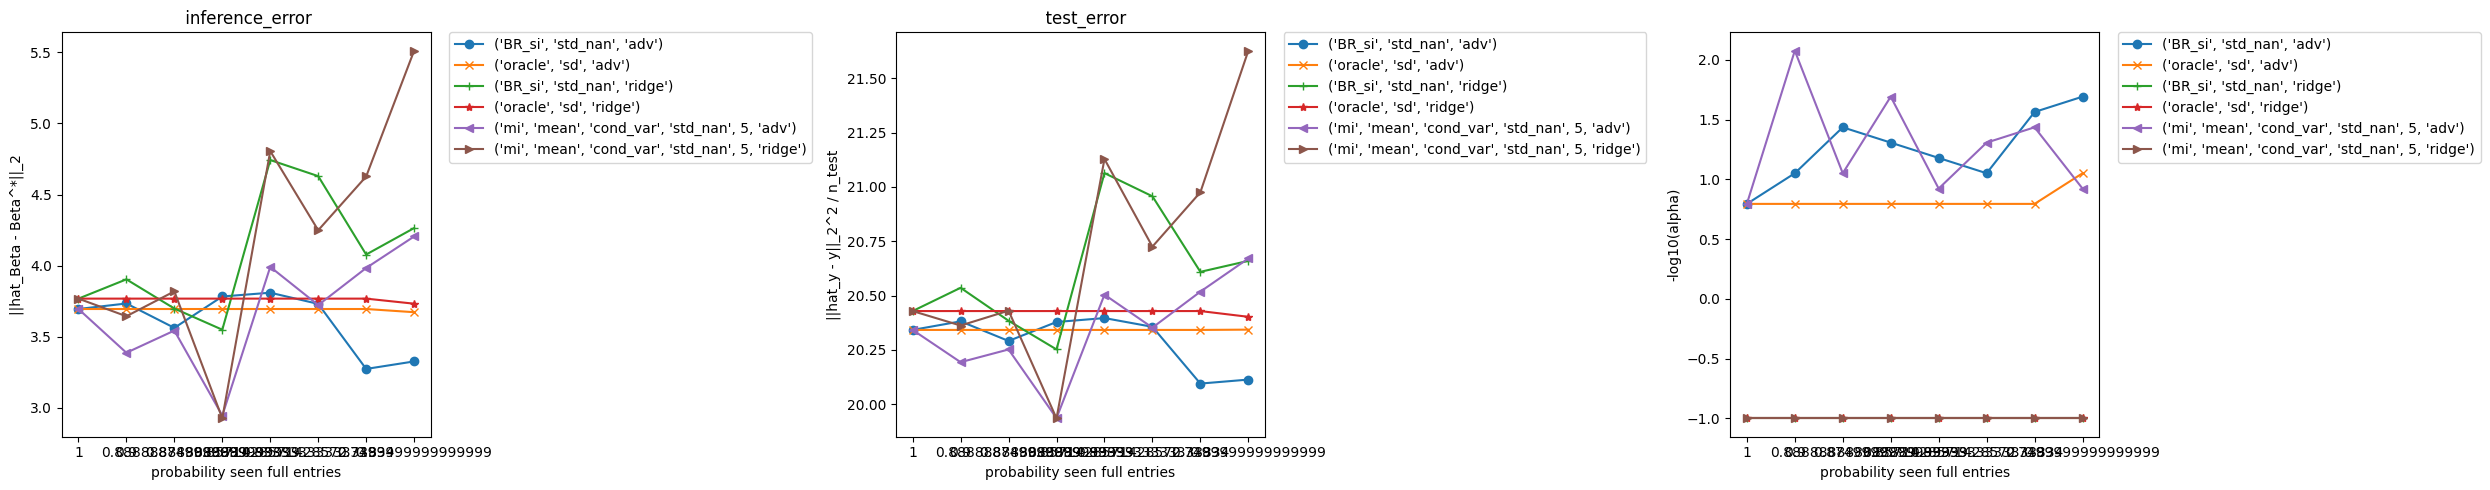

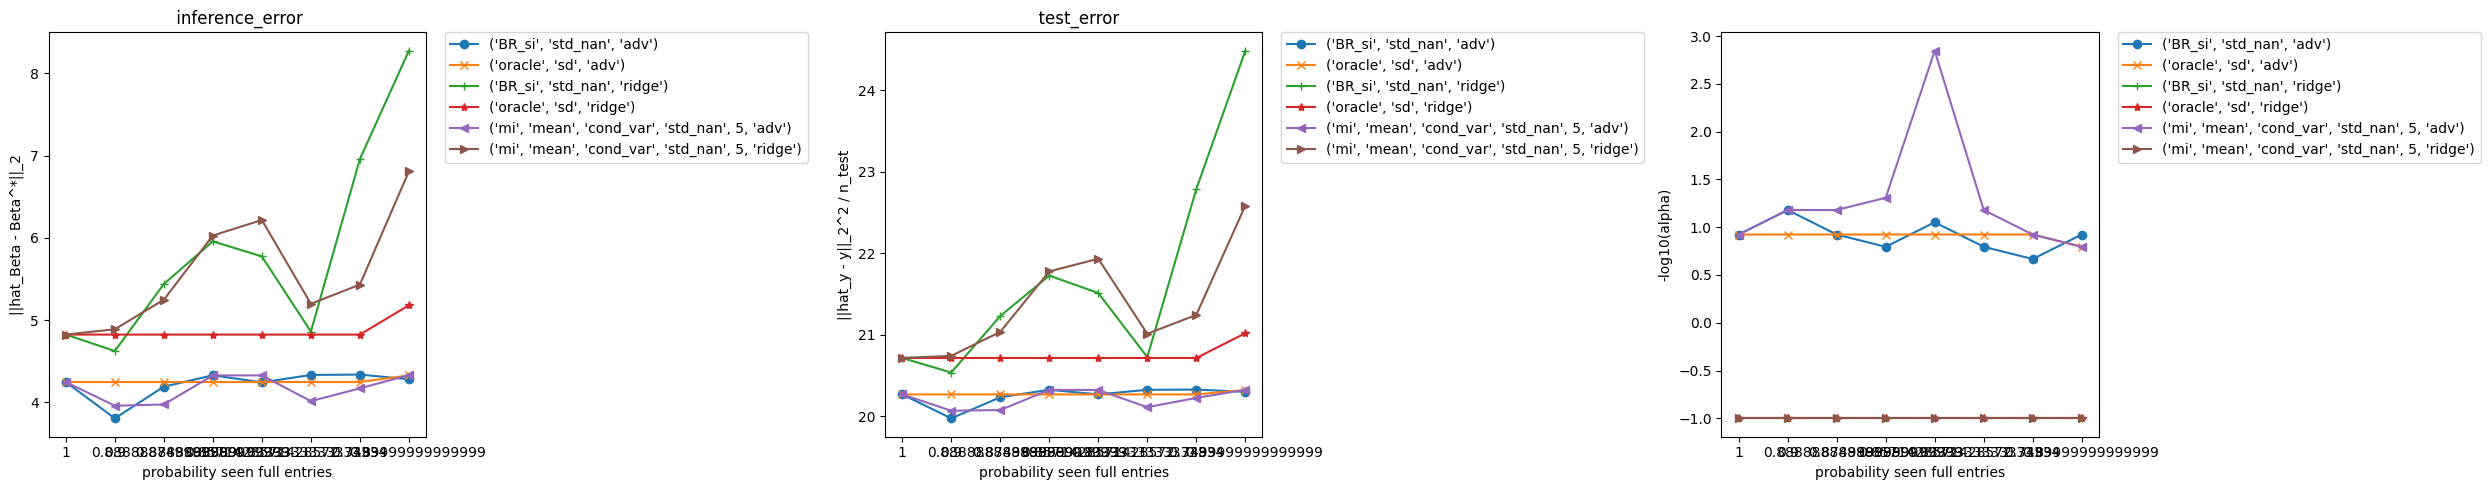

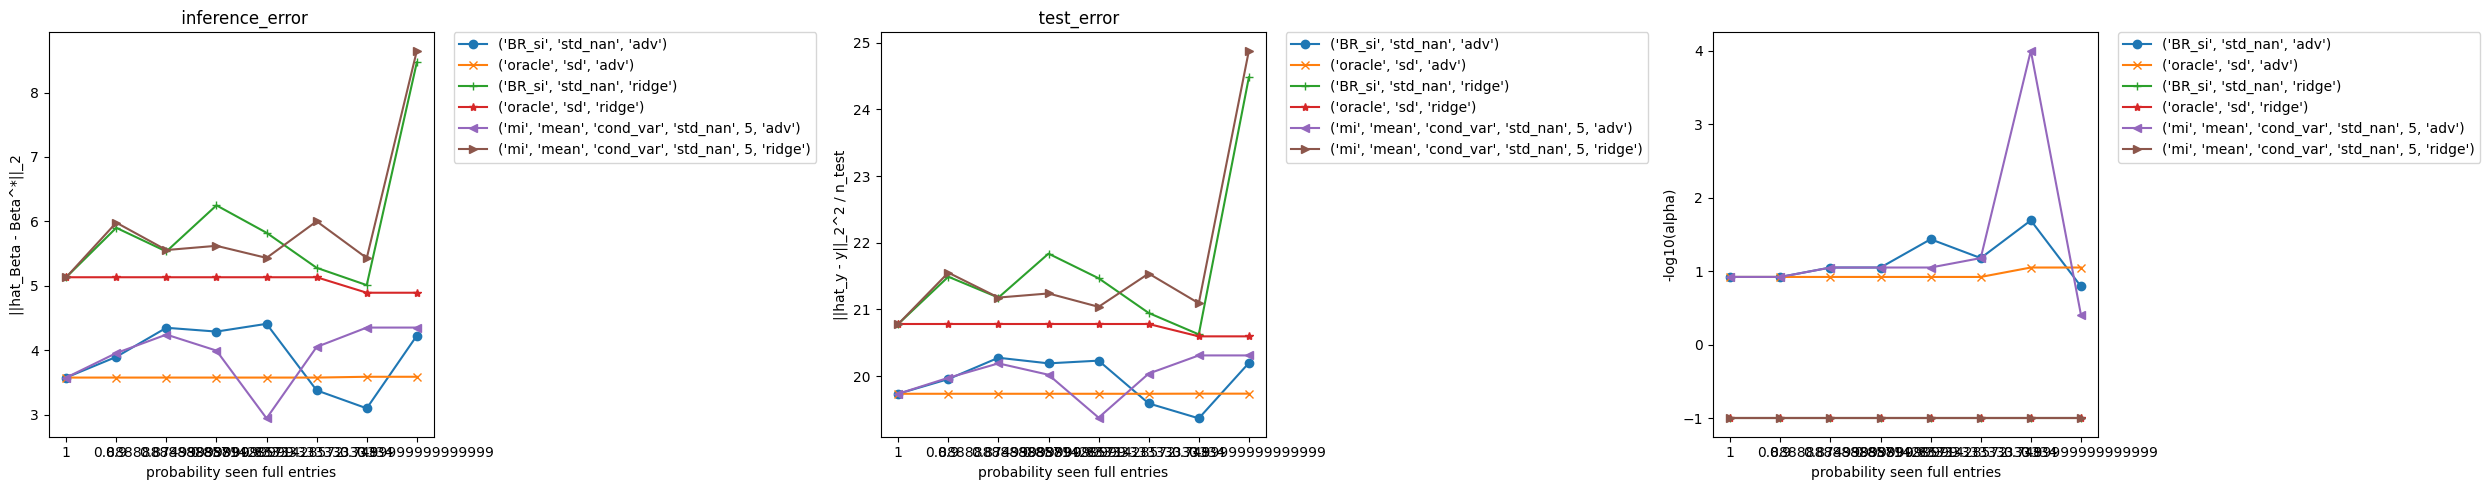

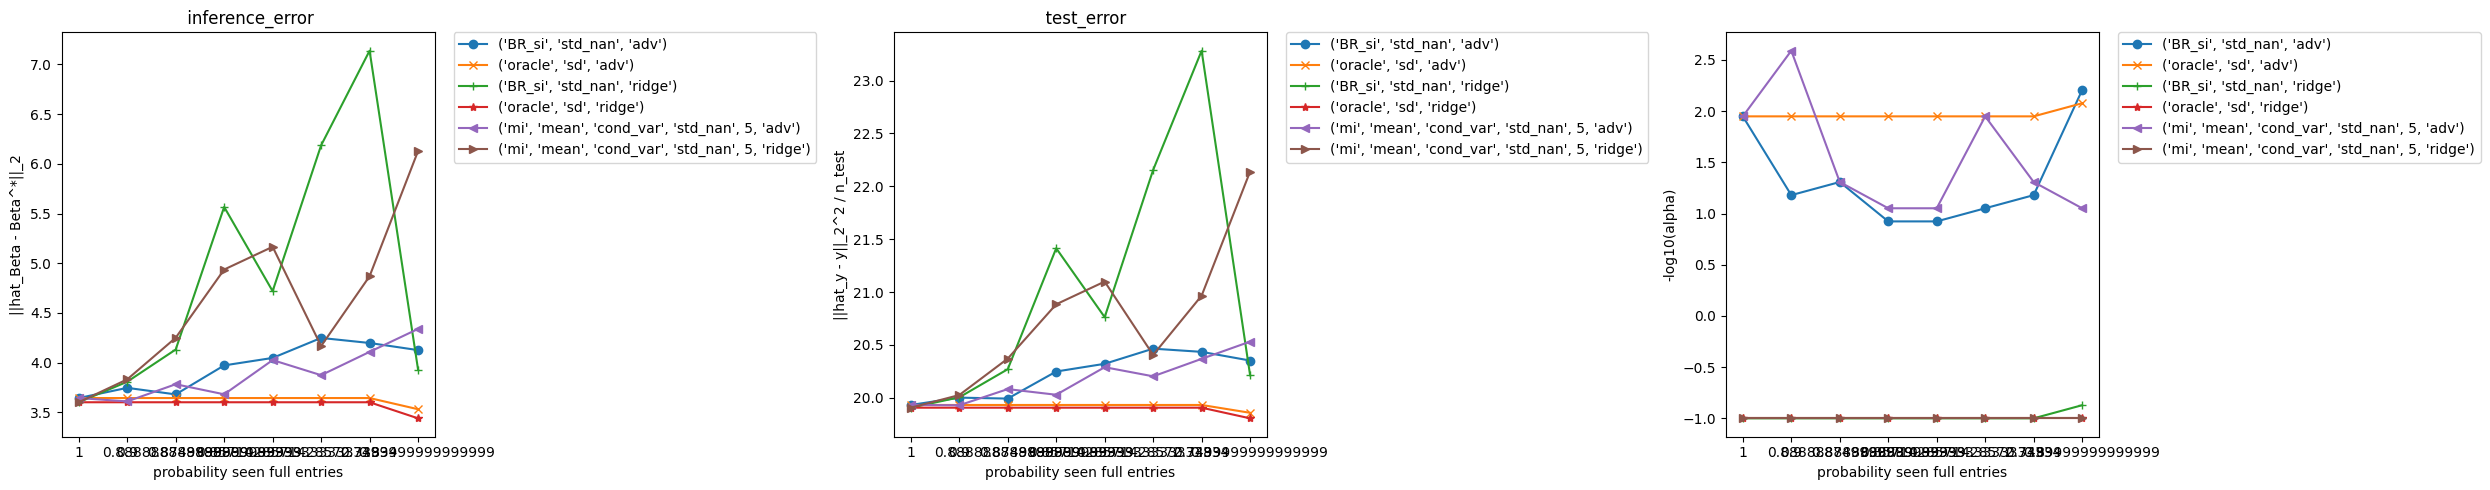

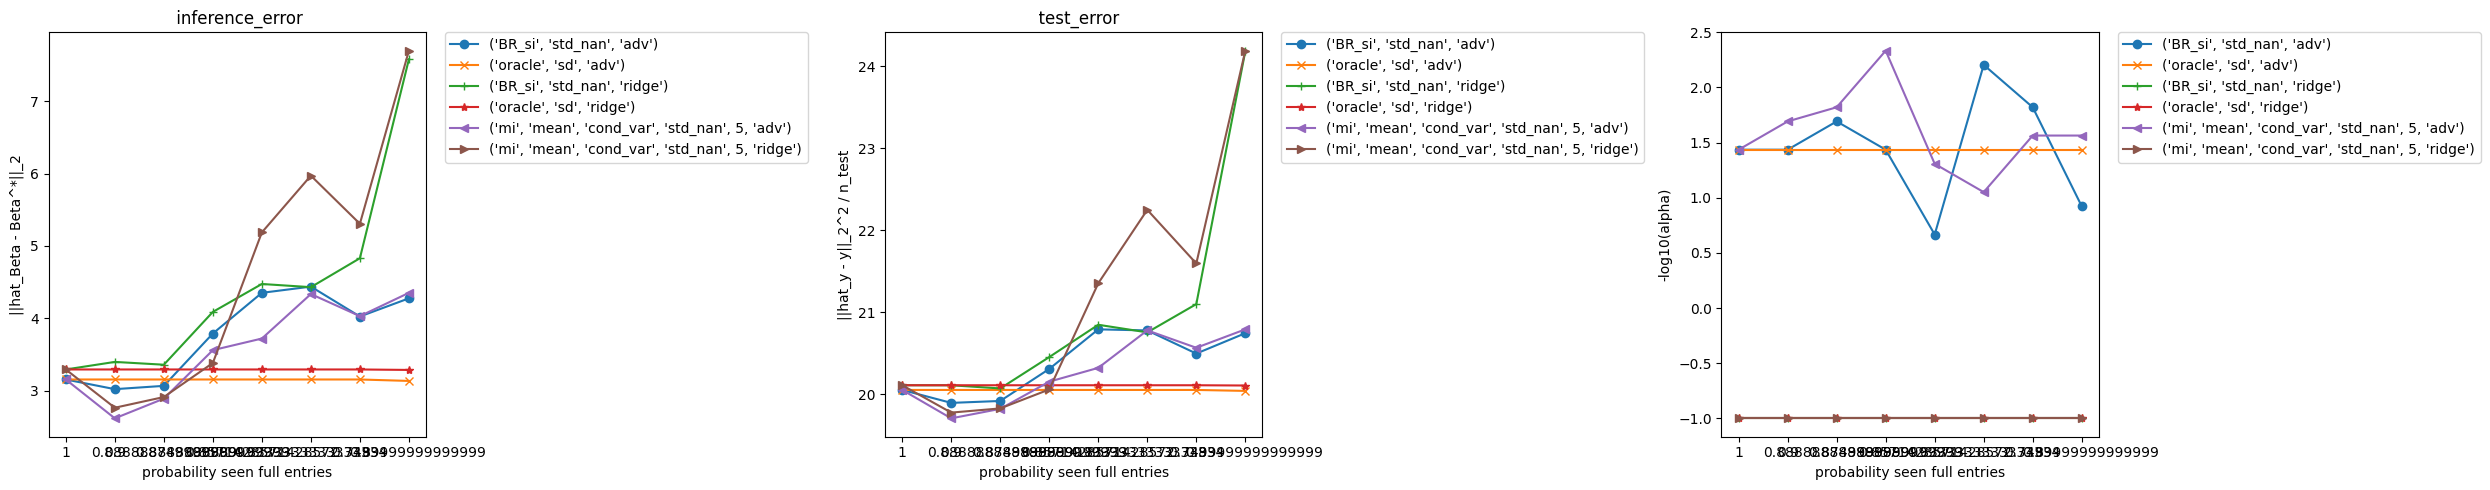

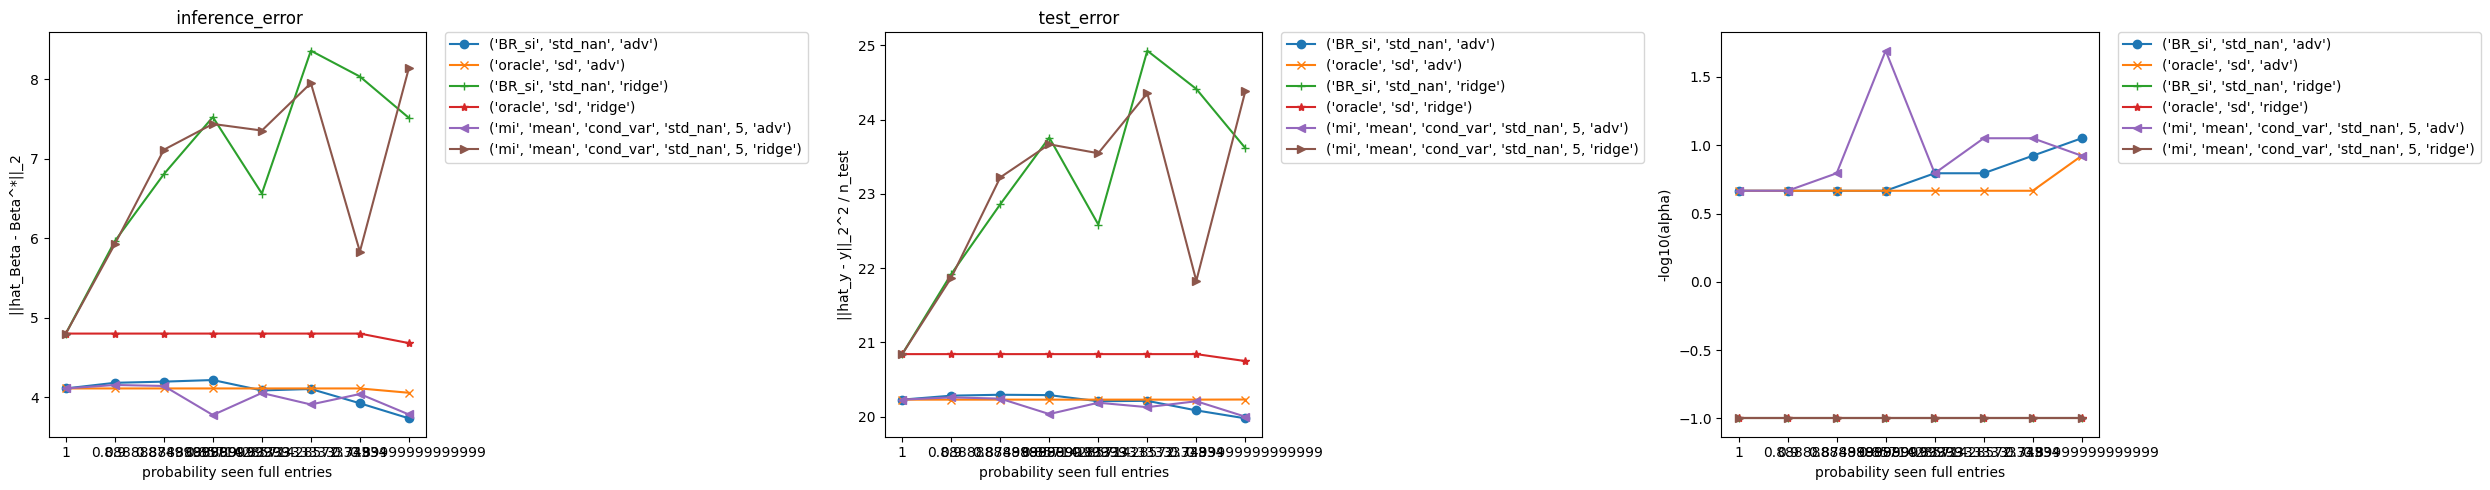

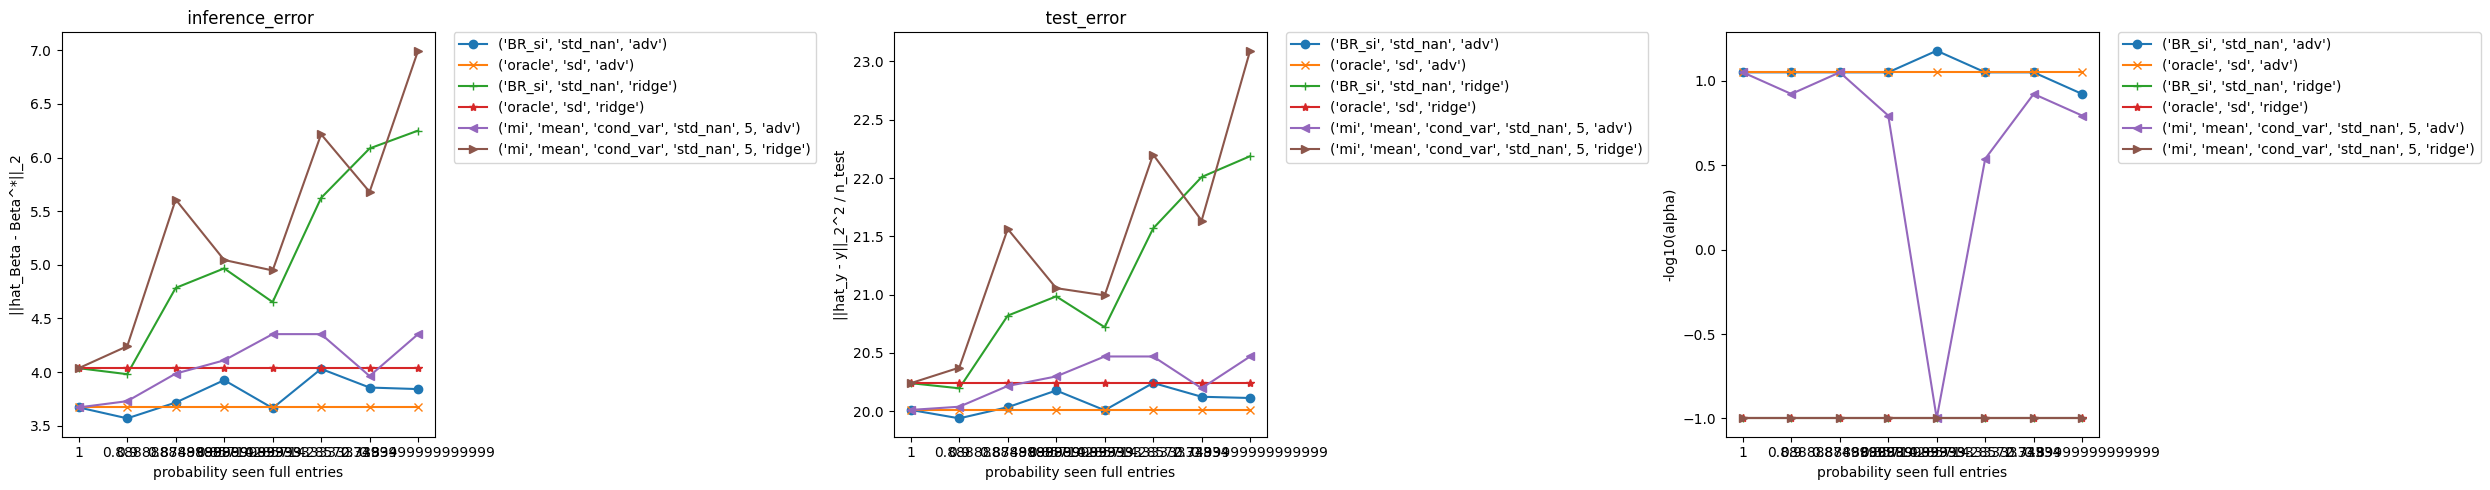

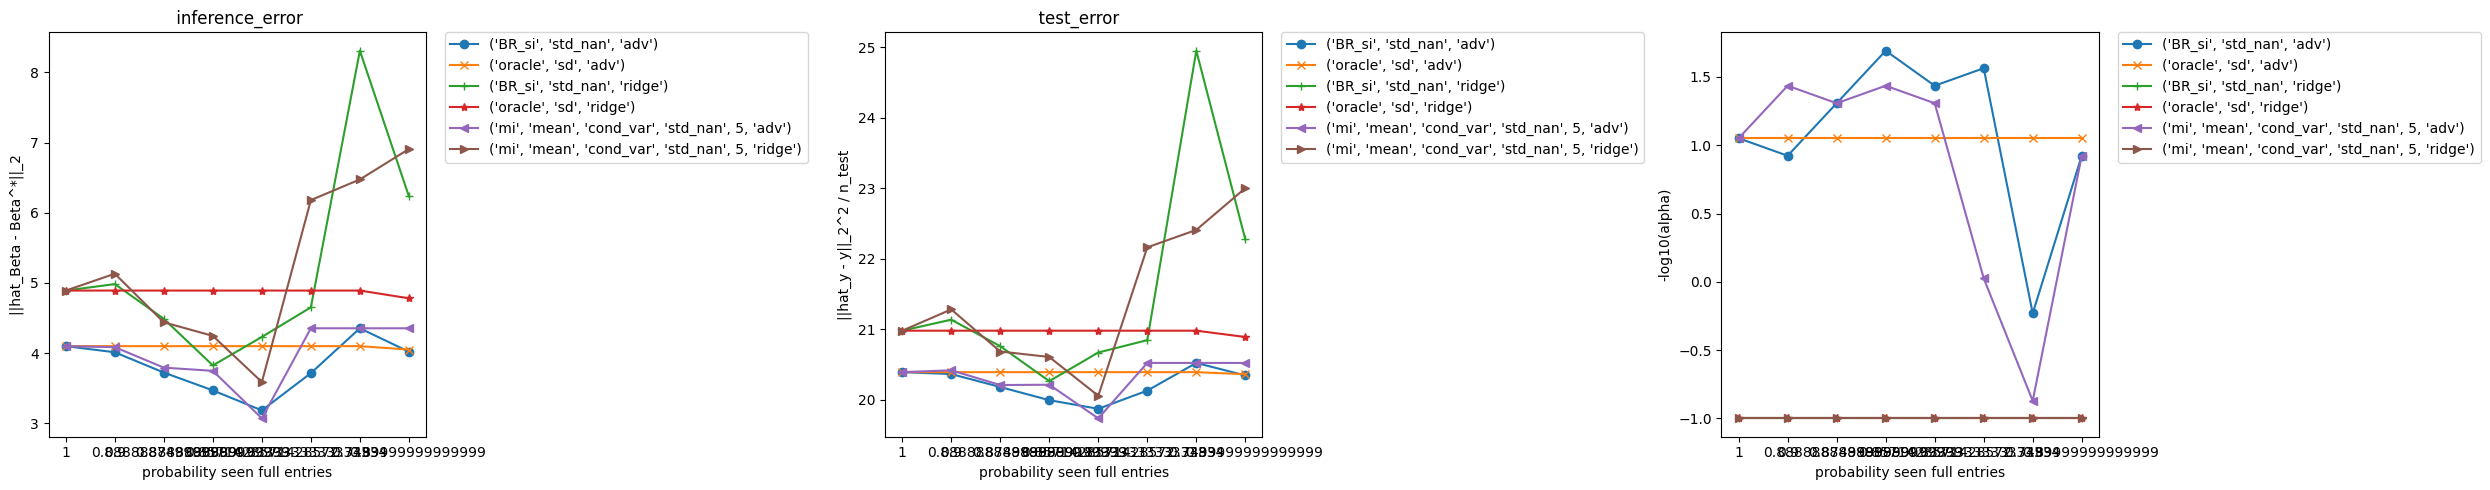

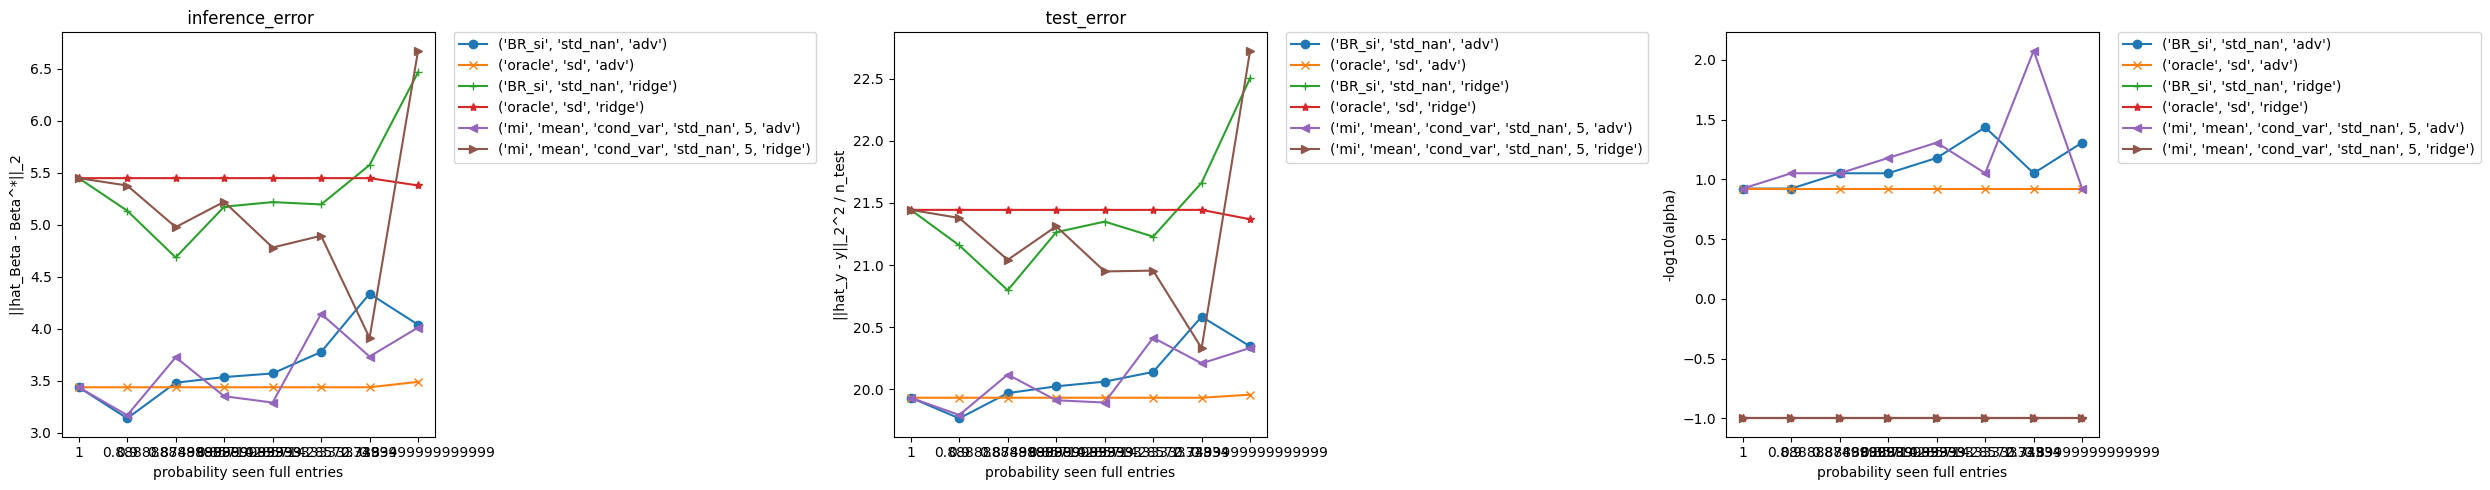

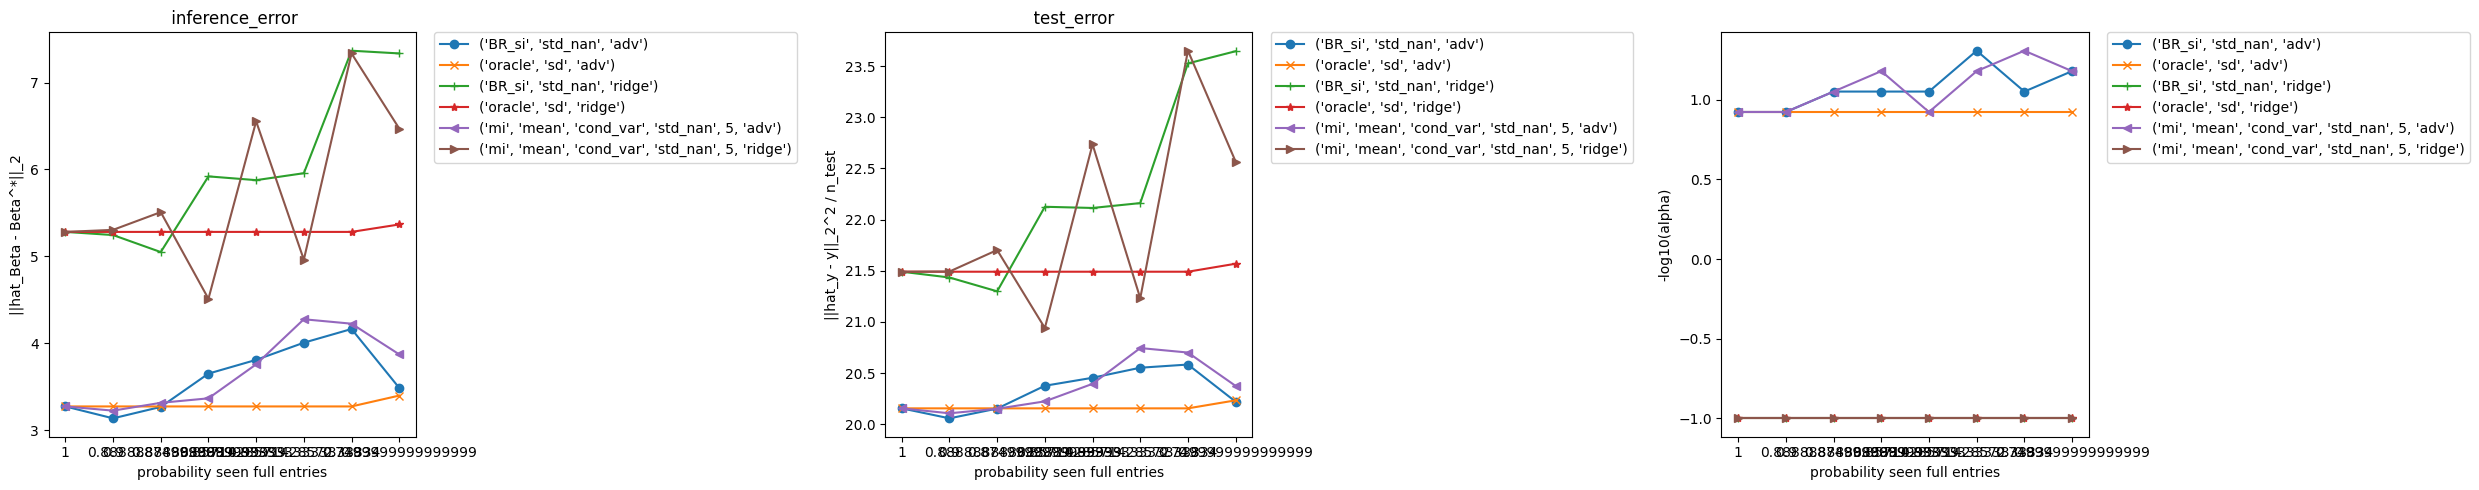

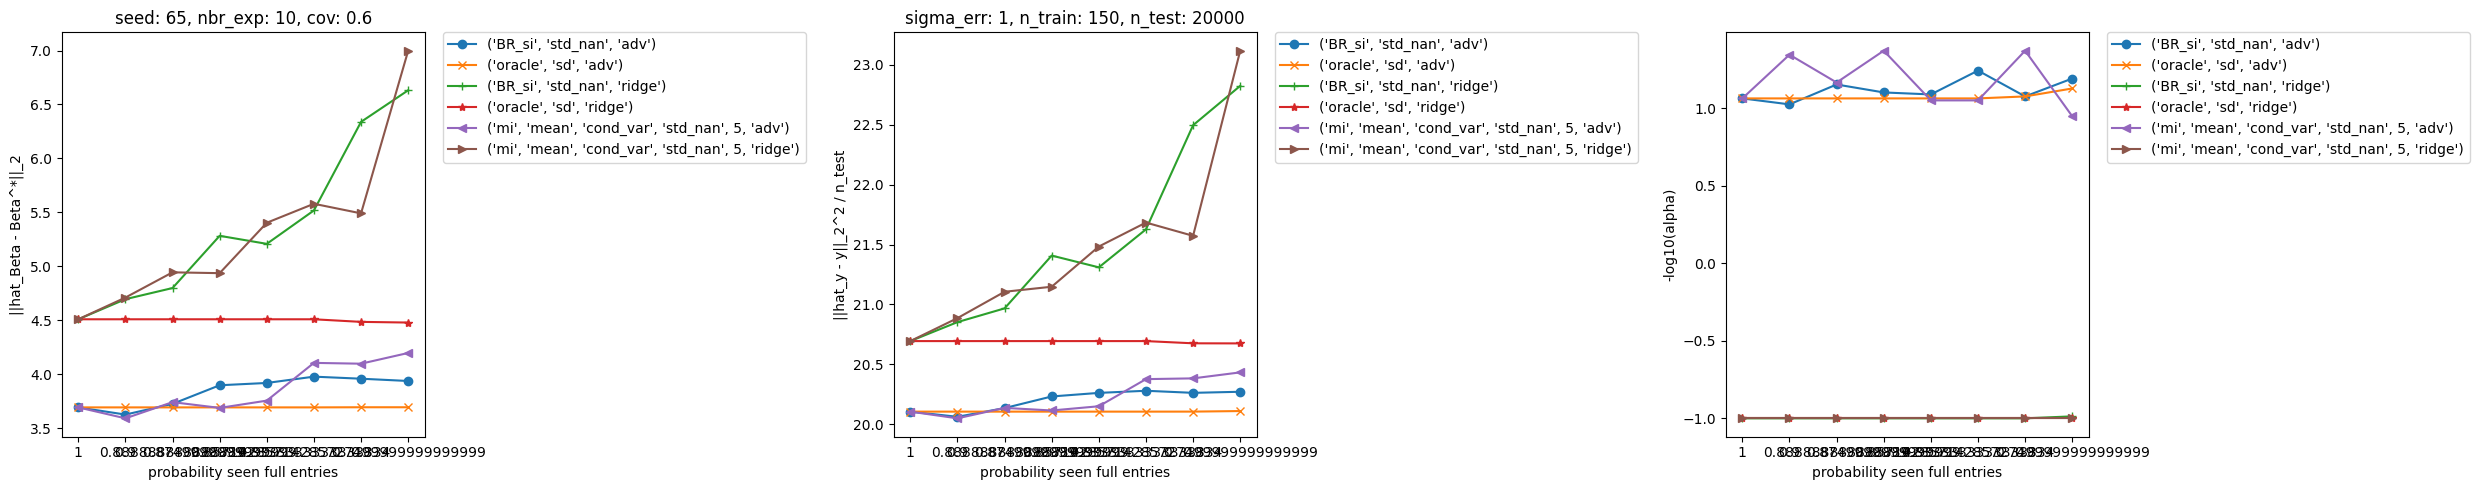

In [19]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [150] * length_vec
error_vec =  [1] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(12)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 2
cov = matr.T @ matr + np.eye(dim) * 0.1
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Uniform', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 10, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 10,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 40, 'n_a_mis':5, 'n_a_rid': 40}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 65
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [12]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[4 2]
  [2 4]]

 [[4 2]
  [4 4]]]
[[4 2]
 [2 4]
 [4 2]
 [4 4]]
[[[3 2]
  [4 3]
  [4 2]]]
[[3 2]
 [4 3]
 [4 2]]
[[2 4]
 [4 4]
 [2 3]
 [2 2]
 [3 3]]
[2 4 4 4 2 3 2 2 3 3]
other
[3 2 3 3 2]
[3 2 3 3 2 3 2 3 3 2 3 2 3 3 2]
other mult
[[4 6]
 [4 6]
 [6 3]]
[[4 6]
 [4 6]
 [6 3]
 [4 6]
 [4 6]
 [6 3]
 [4 6]
 [4 6]
 [6 3]]


In [13]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [14]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [15]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [16]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

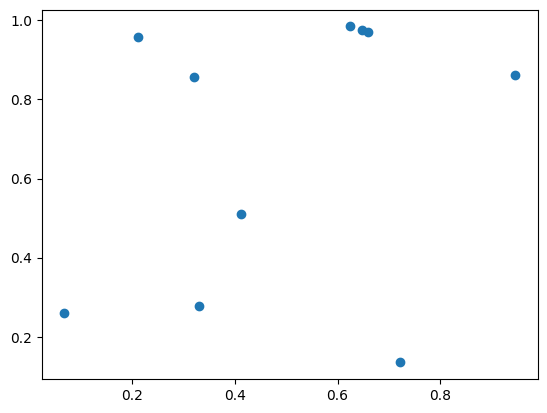

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)




